<a href="https://colab.research.google.com/github/MarkovMarkowitz/MarkovMarkowitz/blob/main/EPAT_PROJECT_v527_EPATIAN_NOERROR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EPAT PROJECT Batch 52

## Moving Skewness Crossover (MSC) Strategy: Rationale, Construction and Backtesting

##### Developed by:
##### Alper Ülkü, Ankara, Turkey
##### alperulku1970@gmail.com
##### linkedin: https://www.linkedin.com/in/alperulku1970/

# Introduction

## Moving Sharpe Ratio Crossover(MSRC) and Moving Skewness Crossover (MSC) Strategy: Rationale, Construction and Backtesting

Synopsis: The moving averages cross over strategy is so well known since it is the basic, easy to understand and relatively easy to implement within trading algo universe.

I tried in this Project a similar strategy but it is called the “Moving Skewness Crossover Strategy”. Here are my assumptions:

1.	He et al., 2013 used skewness in detecting climatic changes, thus long-term skewness may serve for detecting trend of an asset. As every trading asset has seasons or trends. Season for trending can be determined via its skewness of daily returns for M days. This number of days M, varies for every asset, is characteristic of this asset in long term. Thus we safely define “season change of an asset” if M-day skewness of Daily returns changes sign (from negative to positive or positive to negative).

2.	We detect trend due to M-Day Skewness: skewness of the M-day daily returns.
-	We also define N-Skewness (N smaller than M) for an asset is the skewness close-to-close daily returns for N days. We will use N-Skewness for trade entry signal.
-	We will also use kurtosis for selecting the asset to trade. We need to opt for the assets with a certain Kurtosis limit to minimize risk.
-	We will optimize N, M, Skewness_Lower_Limit and Skewness_Upper_Limit for the specific asset.

Strategy: We propose to implement, with M > N > 0, M, N are integers:
- if N-Day-Skewness is GREATER than the value M-Day-Skewness we will square off and enter long trade (BUY)
- if N-Day-Skewness is LESS than the value M-Day-Skewness  we will square off and enter short trade. (SELL)

Herein we prepared Python code and backtested, compared this strategy with an moving average cross over strategy also optimized for SMA and LMA values.

#### References:
- He, W., Wan, S., Jiang, Y., Jin, H., Zhang, W., Wu, Q., & He, T. (2013). Detecting abrupt change on the basis of skewness: Numerical tests and applications. International Journal of Climatology, 33(12), 2713–2727. https://doi.org/10.1002/joc.3624


#### Important Notice: This code contains critical information that is competition sensitive and can only be only reviewed by Quantinsti.


# Table of contents
1. [IMPORT LIBRARIES](#import_lib)
2. [CONSTRUCT CLASS](#construct_class)
3. [SELECT AMONG DATASETS](#select_dataset)
4. [DOWNLOAD FROM YF OR GET DATA LOCALLY](#download_data)
5. [APPLY STRATEGY](#apply_str)
6. [PRINT RESULTS](#print_results)
7. [MY OWN PORTFOLIO PERFORMANCE](#my_pf_perf)
8. [TEARSHEET FOR MY PORTFOLIO](#pf_tearsheet)
9. [AN ALTERNATIVE PORTFOLIO OF BEST PERFORMING ASSETS](#alternative_pf)
10. [DETERMINE WEIGHTS OF THIS ALTERNATIVE PF](#determine_weights)
11. [OPTIONS CALCULATIONS](#options)



In [ ]:

# !pip3 install pandas
# !pip3 install numpy
# !pip3 install matplotlib
# !pip3 install seaborn
# !pip3 install scipy
# !pip3 install nsepy
# !pip3 install datetime
# !pip3 install time
# !pip3 install seaborn
# !pip3 install random
# !pip3 install itertools
# !pip3 install hmmlearn
# !pip3 install yfinance
# !pip3 install glob
# !pip3 install yfinance
# !pip3 install pyfolio
# !pip3 install warnings
# !pip3 install os
# !pip3 install cvxpy

### IMPORT LIBRARIES <a name="import_lib"></a>

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import time
from scipy.stats import pearson3
from scipy.optimize import minimize
from scipy.stats import skew



In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams['axes.grid'] = False
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import HTML

/var/folders/fw/kcckd0xj57gb2qc72smx1m7r0000gn/T/ipykernel_25686/5792512.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [ ]:
import random
from itertools import product
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

print(__doc__)

import matplotlib.pyplot as plt
from hmmlearn import hmm

from glob import glob
import yfinance as yf
import pyfolio as pf
import warnings
import os


Automatically created module for IPython interactive environment


/opt/homebrew/lib/python3.9/site-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [ ]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

### CONSTRUCT CLASS <a name="construct_class"></a>

In [ ]:
class CROSSOVER:
    ## class attribute: We can know the possible values for moving_average and metrics
    ## before creating an object of the class
    moving_average = ( "Simple","exponential","Skewness","Skewness_On_Close","VWAP", "M-Sharpe") # Determine strategy type here
    metrics        = { 'Sharpe':'Sharpe Ratio',                  # Determine metrics
                       'CAGR':'Compound Average Growth Rate',
                       'MDD':'Maximum Drawdown',
                       'NHR':'Normalized Hit Ratio',
                       'OTS':'Optimal trade size'}

    def __init__(self,data,short_window = 20, long_window = 50,
                 moving_average = "Skewness", data_name = None, start = None,end = None ):

        """
         Doc string of the class. We define what class is about here
        """
        self.data=data #the dataframe
        self.data['yr'] = self.data['Date'].dt.year
        self.moving_average = moving_average
        if data_name is None:#the name that will appear on plots
            self.data_name = moving_average
        else:
            self.data_name=data_name
        self.short_window = short_window
        self.long_window = long_window
        self.n_days = (self.data.Date.iloc[-1] - self.data.Date.iloc[0])
        self.start=start #the beginning date of the sample period
        self.end=end #the ending date of the sample period

    def generate_signals(self, DELTA_SKEW=0, charts=True, burn=False, stock_name="AKBNK.IS" ):
        """
        This is an instance method. Only works on an object.
        """
        if self.long_window <= self.short_window: return   # short window cannot be greater than or equal to long window

        if self.moving_average == "Simple":
            self.data["SMA"] = self.data['Close'].rolling(window=self.short_window).mean()
            self.data["LMA"] = self.data['Close'].rolling(window=self.long_window).mean()
        elif self.moving_average == "exponential":
            self.data["SMA"] = self.data['Close'].ewm(span = self.short_window, adjust=True).mean()
            self.data["LMA"] = self.data['Close'].ewm(span = self.long_window, adjust=True).mean()
        elif self.moving_average == "Skewness":
            self.data['Return']=np.log(self.data['Close']/self.data['Close'].shift(1)).dropna()
            self.data["SMA"] = self.data.Return.rolling(window=self.short_window).skew()
            self.data["LMA"] = self.data.Return.rolling(window=self.long_window).skew()
        elif self.moving_average == "VWAP":
            self.data['VWAP'] = (self.data.Volume * (self.data.High + self.data.Low) / 2).cumsum() / self.data.Volume.cumsum()
            self.data["Typical_Price"] = (self.data.High + self.data.Low + self.data['Close'] ) / 3
            self.data["SMA"] = self.data.VWAP
            self.data["LMA"] = self.data.Typical_Price
        elif self.moving_average == "M-Sharpe":
            self.data['Return']=np.log(self.data['Close']/self.data['Close'].shift(1)).dropna()
            self.data["SMA"] = (self.data.Return.rolling(window=self.short_window).mean() / self.data.Return.rolling(window=self.short_window).std()) * (252**0.5)
            self.data["LMA"] = (self.data.Return.rolling(window=self.long_window).mean() / self.data.Return.rolling(window=self.long_window).std()) * (252**0.5)
        else:
            raise Exception("Not a valid type")

        self.data["_lag1_SMA"] = self.data.SMA.shift(1)
        self.data["_lag1_LMA"] = self.data.LMA.shift(1)

        ## creating signal
        buy_mask = (self.data.SMA > self.data.LMA - DELTA_SKEW) & (self.data._lag1_SMA < self.data._lag1_LMA  - DELTA_SKEW)
        sell_mask = (self.data.SMA < self.data.LMA + DELTA_SKEW) & (self.data._lag1_SMA > self.data._lag1_LMA + DELTA_SKEW)
        self.data['Delta'] = self.data.SMA - self.data.LMA

        self.data['signal'] = np.nan
        self.data.loc[buy_mask,'signal'] = +1
        self.data.loc[sell_mask,'signal'] = -1
        if burn:
            burn_period = 2*self.long_window
            self.data.loc[:burn_period,"signal"] = np.nan

        # 19.02
        self.data.signal = self.data.signal.fillna(method="bfill") ## ffill idi



        mask = (self.data.signal != self.data.signal.shift(1)) & (self.data.signal.notnull())
        self.data['trade_num'] = np.where(mask,1,0).cumsum()

        ## display chart
        if charts:
            plt.plot(self.data['Date'],self.data['SMA'],color='red', label=f'SMA = {self.short_window}')
            plt.plot(self.data['Date'],self.data['LMA'],color='blue', label=f'LMA = {self.long_window}')

            #******** DELTA SKEWNESS PLOT EKLEDİK *************************
            plt.plot(self.data['Date'],self.data['Delta'],color='green')

            #plt.title('%s %s Strategy Backtest'%(self.data_name)%(stock_name) )
            plt.title(f"{stock_name} {self.data_name} Strategy Backtest")
            plt.legend(loc=0)
            d_color = {}
            d_color[1] = '#90ee90'  ## light green
            d_color[-1] = "#ffcccb" ## light red

            j = 0
            for i in range(1,self.data.shape[0]):
                if np.isnan(self.data.signal[i-1]):
                    j=i
                elif (self.data.signal[i-1] == self.data.signal[i]) and (i< (self.data.shape[0]-1)):
                    continue
                else:
                    plt.axvspan(self.data['Date'][j], self.data['Date'][i],
                               alpha=0.5,label="interval")
                    j = i
            plt.grid(True)
            plt.show()
        return self.data.Delta, self.data.signal

    def signal_performance(self, allocation):
        """
        Another instance method
        """
        if self.long_window <= self.short_window: return
        self.allocation=allocation

        #creating returns and portfolio value series
        self.data['Return']=np.log(self.data['Close']/self.data['Close'].shift(1))

        self.data['S_Return']=self.data['signal'].shift(1)*self.data['Return']
        self.data['Market_Return']=self.data['Return'].expanding().sum()
        self.data['Strategy_Return']=self.data['S_Return'].expanding().sum()
        self.data['Portfolio Value']=((self.data['Strategy_Return']+1)*self.allocation)
        self.data['Wins']=np.where(self.data['S_Return'] > 0,1,0)
        self.data['Losses']=np.where(self.data['S_Return'] < 0,1,0)

        ## Daywise Performance
        d_perform = {}
        d_perform['Returns']=self.data['Return'].sum()
        d_perform['R_Mean']=self.data['Return'].mean()
        d_perform['R_Std_Dev']=self.data['Return'].std()
        d_perform['R_Skew']=self.data['Return'].skew() # 12 day window for skew
        d_perform['R_Kurtosis']=self.data['Return'].kurt()
        d_perform['R_Sharpe'] = self.data["Return"].mean() / self.data["Return"].std() * (252**.5)

        d_perform['Str_Returns']=self.data['S_Return'].sum()
        d_perform['Str_R_Mean']=self.data['S_Return'].mean()
        d_perform['Str_R_Std_Dev']=self.data['S_Return'].std()
        d_perform['Str_R_Skew']=self.data['S_Return'].skew()
        d_perform['Str_R_Kurtosis']=self.data['S_Return'].kurt()
        d_perform['SharpeRatio'] = self.data["S_Return"].mean() / self.data["S_Return"].std() * (252**.5)

        d_perform['TotalWins']=self.data['Wins'].sum()
        d_perform['TotalLosses']=self.data['Losses'].sum()
        d_perform['TotalTrades']=d_perform['TotalWins']+d_perform['TotalLosses']

        d_perform['HitRatio']=round(d_perform['TotalWins']/d_perform['TotalTrades'],2)
        d_perform['CAGR'] = ((1+self.data['Strategy_Return']).iloc[-1])**(365.25/self.n_days.days) -1
        d_perform['MaxDrawdown']=(1.0-self.data['Portfolio Value']/self.data['Portfolio Value'].cummax()).max()


        self.daywise_performance = pd.Series(d_perform)

        ## Tradewise performance
        _df = self.data.groupby(["signal","trade_num"]).S_Return.sum().reset_index()
        _df['Wins']  =np.where(_df['S_Return'] > 0,1,0)
        _df['Losses']=np.where(_df['S_Return'] < 0,1,0)
        d_tp = {}
        d_tp.update(_df[["Wins","Losses"]].sum().rename({'Wins':'TotalWins','Losses':'TotalLosses'}).to_dict())
        d_tp['TotalTrades'] = d_tp["TotalWins"] + d_tp["TotalLosses"]
        d_tp['HitRatio'] =  np.round(d_tp["TotalWins"] / d_tp['TotalTrades'],4)
        d_tp['AvgWinRet'] = np.round(_df[_df.Wins==1].S_Return.mean(),4)
        d_tp['AvgLossRet'] = np.round(_df[_df.Losses==1].S_Return.mean(),4)
        d_tp['WinByLossRet'] = np.round(abs(d_tp['AvgWinRet']/d_tp['AvgLossRet']),2)
        d_tp['RetVar'] = np.round(_df.S_Return.std(),4)
        _sum = _df.groupby("Wins").S_Return.sum()
        d_tp['NormHitRatio'] = np.round(_sum[1]/_sum.abs().sum(),4)
        d_tp['OptimalTradeSize'] = self.kelly(p = d_tp['HitRatio'], b = d_tp['WinByLossRet'])
        d_tp['S_Return'] = self.data['S_Return']
        self.tradewise_performance = pd.Series(d_tp)
        return(self.data['S_Return'])

    @staticmethod
    def kelly(p,b):
        """
        Static method: No object or class related arguments
        p: win prob, b: net odds received on wager, output(f*) = p - (1-p)/b

        Spreadsheet example
            from sympy import symbols, solve, diff
            x = symbols('x')
            y = (1+3.3*x)**37 *(1-x)**63
            solve(diff(y, x), x)[1]
        Shortcut
            .37 - 0.63/3.3
        """
        return np.round(p - (1-p)/b,4)

    def plot_performance(self, allocation=1, charts=True, stock_name = "AKBNK.IS"):
        #intializing a variable for initial allocation
        #to be used to create equity curve
        self.signal_performance(allocation)

        #yearly performance
        self.yearly_performance()

        #Plotting the Performance of the strategy
        if (charts == True):
            plt.plot(self.data['Date'],self.data['Market_Return'],color='red', label='Market Returns')
            plt.plot(self.data['Date'],self.data['Strategy_Return'],color='blue', label= 'Strategy Returns')
            #plt.title('%s Strategy Backtest'%(self.data_name))
            plt.title(f"{stock_name} {self.data_name} Strategy Backtest")
            plt.legend(loc=0)
            plt.tight_layout()
            plt.grid(True)
            plt.show()

            #pf.create_simple_tear_sheet(self.data['Portfolio Value'], benchmark_rets=True)

            plt.plot(self.data['Date'],self.data['Portfolio Value'], color='blue')
            #plt.title('%s Portfolio Value'%(self.data_name))
            plt.title(f"{stock_name} {self.data_name} Portfolio Value")
            plt.grid(True)
            plt.show()

    def yearly_performance(self):
        """
        Instance method
        Adds an instance attribute: yearly_df
        """
        _yearly_df = self.data.groupby(['yr','signal']).S_Return.sum().unstack()
        _yearly_df.rename(columns={-1.0:'Sell',1.0:'Buy'}, inplace=True)
        _yearly_df['Return'] = _yearly_df.sum(1)

        # yearly_df
        self.yearly_df = _yearly_df.style.bar(color=["#ffcccb",'#90ee90'], align = 'zero').format({
            'Sell': '{:,.2%}'.format,'Buy': '{:,.2%}'.format,'Return': '{:,.2%}'.format})


    def update_metrics(self):
        """
        Called from the SMA_LMA_matrix class method
        """
        d_field = {}
        if self.long_window > self.short_window:
            d_field['Sharpe'] = self.daywise_performance.SharpeRatio
            d_field['CAGR'] = self.daywise_performance.CAGR
            d_field['MDD'] = round(self.daywise_performance.MaxDrawdown,2)
            d_field['NHR'] = self.tradewise_performance.NormHitRatio
            d_field['OTS'] = self.tradewise_performance.OptimalTradeSize

        return d_field

    @classmethod
    def SMA_LMA_matrix(cls,data, LMA_range, SMA_range, metrics, moving_average = "exponential", optimal_sol = True, charts = True):
        """
        This is a class method. First argument is a class.
        """
        c_green = sns.light_palette("green", as_cmap=True)
        c_red = sns.light_palette("red", as_cmap=True)

        d_mats = {m:[] for m in metrics}

        for l in LMA_range:
            d_row = {m:[] for m in metrics}
            for s in SMA_range:
                obj = cls(data, s, l, moving_average) ## object being created from the class
                obj.generate_signals(charts=False)
                obj.signal_performance(100)
                d_field = obj.update_metrics()
                for m in metrics: d_row[m].append(d_field.get(m,np.nan))
            for m in metrics: d_mats[m].append(d_row[m])

        d_df = {m:pd.DataFrame(d_mats[m], index=LMA_range, columns=SMA_range) for m in metrics}

        def optimal(_df):
            """
            This is a function inside a function.
            We could have created it outside the class if needed, but that would made it harder to relate.
            """
            _df = _df.stack().rank()
            _df = (_df - _df.mean())/_df.std()
            return _df.unstack()

        if optimal_sol:
            d_df['Signal'] = 0
            if 'Sharpe' in metrics: d_df['Signal'] += 2*optimal(d_df['Sharpe']) #2*optimal(d_df['Sharpe'])
            if 'NHR' in metrics: d_df['Signal'] += optimal(d_df['NHR'])
            if 'CAGR' in metrics: d_df['Signal'] += optimal(d_df['CAGR']) #optimal(d_df['CAGR'])
            if 'MDD' in metrics: d_df['Signal'] -= 2*optimal(d_df['MDD'])   #2*optimal(d_df['MDD'])

            l_i,s_i = np.unravel_index(np.nanargmax(d_df['Signal'].values), d_df['Signal'].shape)
            print(f"Most optimal cross-over pair is SMA:{SMA_range[s_i]}, LMA:{LMA_range[l_i]}")
            metrics.insert(0,'Signal')

        if (charts==True):
            for m in metrics:
                display(HTML(d_df[m].style.background_gradient(axis=None, cmap=
                    c_red if m=="MDD" else c_green).format(
                    ("{:,.2}" if m in ["Sharpe","Signal"] else "{:.2%}")).set_caption(m).render()))

        return d_df, SMA_range[s_i], LMA_range[l_i]



    def drawdowns(equity_curve):
        i = np.argmax(np.maximum.accumulate(equity_curve.values) - equity_curve.values) # end of the period
        j = np.argmax(equity_curve.values[:i]) # start of period

        drawdown=abs(100.0*(equity_curve[i]-equity_curve[j]))

        DT=equity_curve.index.values

        start_dt=pd.to_datetime(str(DT[j]))
        MDD_start=start_dt.strftime ("%Y-%m-%d")

        end_dt=pd.to_datetime(str(DT[i]))
        MDD_end=end_dt.strftime ("%Y-%m-%d")

        NOW=pd.to_datetime(str(DT[-1]))
        NOW=NOW.strftime ("%Y-%m-%d")

        MDD_duration=np.busday_count(MDD_start, MDD_end)

        try:
            UW_dt=equity_curve[i:].loc[equity_curve[i:].values>=equity_curve[j]].index.values[0]
            UW_dt=pd.to_datetime(str(UW_dt))
            UW_dt=UW_dt.strftime ("%Y-%m-%d")
            UW_duration=np.busday_count(MDD_end, UW_dt)
        except:
            UW_dt="0000-00-00"
            UW_duration=np.busday_count(MDD_end, NOW)
        return MDD_start, MDD_end, MDD_duration, drawdown, UW_dt, UW_duration


### SELECT AMONG DATASETS <a name="select_dataset"></a>

In [ ]:
US_Top_10 = [  "IBM", "STT", "MSFT","VZ", "TGT","WFC","NVDA","BA","GOOG"]

US_Best = [ "NVDA" ]

TSLA =[ "TSLA", "AMZN", "GOOGL" ]
FANG = ["FANG"]

DOW30 =[ "TSLA","AXP","AMGN","AAPL","BA","CAT","CSCO","CVX","GS","HD","HON","IBM","INTC",
         "JNJ","KO","JPM","MCD","MMM","MRK","MSFT","NKE","PG","TRV","UNH","CRM",
         "VZ","V","WBA","WMT","DIS","DOW"]

CHAIKIN = [ "FTNT", "NDAQ", "BX", "LYV", "FFIV", "FANG", "FMC", "FCPI"]

US_Stocks =      [ "GE", "PYPL",
                   "SYNA","QCOM","NVDA","NFLX","AVGO","FSLR","FB",
                   "BAC", "AMZN","T",   "GOOG","TSLA",
                   "XOM", "C",   "DIS",
                   "WFC", "GM",  "TGT", "SBUX", "ORCL",
                   "NVDA","FDX", "CL",  "TM",   "STT", "GDX", "NXPI", "OLED",
                   "NKE", "CVS", "BIDU", "BABA" ]

BIST50 = [ "XU100.IS","AKBNK.IS","AKSEN.IS","ALARK.IS", "ARCLK.IS", "ARDYZ.IS", "ARSAN.IS", "BIMAS.IS",
           "GARAN.IS","GSDHO.IS","HDFGS.IS", "INFO.IS" , "ISCTR.IS", "ISMEN.IS", "BRYAT.IS", "DOHOL.IS",
           "KAREL.IS","KCHOL.IS","KRDMD.IS", "SISE.IS" , "SKTAS.IS", "TAVHL.IS", "EKGYO.IS", "ENJSA.IS",
           "THYAO.IS","TUPRS.IS","VESBE.IS", "BERA.IS" , "XU100.IS", "CLEBI.IS", "GLYHO.IS", "GUBRF.IS",
           "HEKTS.IS","INDES.IS","SASA.IS" , "TTRAK.IS", "PKART.IS", "FROTO.IS", "HALKB.IS", "IPEKE.IS",
           "KORDS.IS","TKFEN.IS","EREGL.IS", "KCHOL.IS", "ASELS.IS", "YKBNK.IS", "KARSN.IS", "PETKM.IS",
           "ARENA.IS","KOZAA.IS", "KOZAL.IS", "MGROS.IS", "ODAS.IS" , "OTKAR.IS", "PGSUS.IS",
           "SAHOL.IS","SKBNK.IS","SOKM.IS" , "TCELL.IS", "TOASO.IS", "TSKB.IS" , "TTKOM.IS", "TURSG.IS",
           "VAKBN.IS","VESTL.IS"
       ]

BIST100_1 = [ "AKBNK.IS","AKSEN.IS","ALARK.IS", "ARCLK.IS", "ARDYZ.IS", "ARSAN.IS", "BIMAS.IS",
           "GARAN.IS","GSDHO.IS","HDFGS.IS", "INFO.IS" , "ISCTR.IS", "ISMEN.IS", "BRYAT.IS", "DOHOL.IS",
           "KAREL.IS","KCHOL.IS","KRDMD.IS", "SISE.IS" , "SKTAS.IS", "TAVHL.IS", "EKGYO.IS", "ENJSA.IS",
           "THYAO.IS","TUPRS.IS","VESBE.IS", "BERA.IS" , "XU100.IS", "CLEBI.IS", "GLYHO.IS", "GUBRF.IS",
           "HEKTS.IS","INDES.IS","SASA.IS" , "TTRAK.IS", "PKART.IS", "FROTO.IS", "HALKB.IS", "IPEKE.IS",
           "KORDS.IS","TKFEN.IS","EREGL.IS", "KCHOL.IS", "ASELS.IS", "YKBNK.IS", "KARSN.IS", "PETKM.IS",
           "INDES.IS","ARENA.IS","KOZAA.IS", "KOZAL.IS", "MGROS.IS", "ODAS.IS" , "OTKAR.IS", "PGSUS.IS",
           "SAHOL.IS","SKBNK.IS","SOKM.IS" , "TCELL.IS", "TOASO.IS", "TSKB.IS" , "TTKOM.IS", "TURSG.IS",
           "VAKBN.IS","VESTL.IS","ADESE.IS", "AEFES.IS", "AKSA.IS" , "ALGYO.IS", "ALKIM.IS",
           "AYDEM.IS","BAGFS.IS" ]

BIST100_2 = [ "ALGYO.IS", "BRMEN.IS", "CANTE.IS", "CCOLA.IS", "CEMAS.IS", "CIMSA.IS",
           "CMENT.IS","DENGE.IS", "DEVA.IS", "DOAS.IS", "DOHOL.IS", "ECILC.IS", "EGEEN.IS", "ENKAI.IS",
           "ERBOS.IS", "ESEN.IS", "ETILR.IS", "GENIL.IS", "GESAN.IS", "GLYHO.IS", "GOZDE.IS", "ISBIR.IS",
           "ISDMR.IS", "ISFIN.IS", "ISGYO.IS", "ISYAT.IS", "IZMDC.IS", "KARTN.IS", "KENT.IS", "KERVT.IS",
           "KLNMA.IS", "KORDS.IS", "KRVGD.IS", "LOGO.IS", "MAVI.IS", "NTHOL.IS", "OTTO.IS", "OYAKC.IS",
           "PARSN.IS", "PETKM.IS", "PGSUS.IS", "QNBFB.IS", "QNBFL.IS", "QUAGR.IS", "RTALB.IS", "SARKY.IS",
           "SELEC.IS", "TBORG.IS", "TKNSA.IS", "TRGYO.IS", "ULKER.IS", "UTPYA.IS",
           "VERUS.IS", "YATAS.IS", "ZOREN.IS", "ZRGYO.IS"
          ]

BIST100EX = [ "AKBNK.IS","AKSEN.IS","ALARK.IS", "ARCLK.IS", "ARDYZ.IS", "ARSAN.IS", "BIMAS.IS",
            "GSDHO.IS","HDFGS.IS", "INFO.IS" , "ISCTR.IS", "ISMEN.IS", "BRYAT.IS", "DOHOL.IS", #garan çıktı
            "KAREL.IS","KCHOL.IS","KRDMD.IS", "SISE.IS" , "SKTAS.IS", "TAVHL.IS", "EKGYO.IS", "ENJSA.IS",

            "THYAO.IS","TUPRS.IS", "GUBRF.IS", # XU100  CLEBI attık BERA ekledik VESBE attık
            "HEKTS.IS","INDES.IS",
            "TTRAK.IS", "PKART.IS", "FROTO.IS", "HALKB.IS", "IPEKE.IS",
            "KORDS.IS","TKFEN.IS","EREGL.IS", "ASELS.IS", "YKBNK.IS", "KARSN.IS", "PETKM.IS",
            "ARENA.IS","KOZAA.IS", "KOZAL.IS", "MGROS.IS", "ODAS.IS" , "OTKAR.IS",
            "SAHOL.IS","SKBNK.IS","SOKM.IS" , "TCELL.IS", "TOASO.IS", "TSKB.IS" , "TTKOM.IS", "TURSG.IS",
            "VAKBN.IS","VESTL.IS","ADESE.IS", "AEFES.IS", "AKSA.IS" , "ALGYO.IS", "ALKIM.IS",
            "BAGFS.IS","BRMEN.IS","CEMAS.IS", "CIMSA.IS", # CANTE, AYDEM CCOLA attık
            "CMENT.IS","DENGE.IS","DEVA.IS" , "DOAS.IS" , "DOHOL.IS", "ECILC.IS", "EGEEN.IS", "ENKAI.IS",
            "ERBOS.IS","ETILR.IS","GOZDE.IS", "ISBIR.IS", # GLYHO attık
            "ISDMR.IS","ISFIN.IS","ISGYO.IS", "ISYAT.IS", "IZMDC.IS", "KARTN.IS", "KENT.IS", "KERVT.IS",
            "KLNMA.IS","LOGO.IS" ,"MAVI.IS" , "NTHOL.IS", "OTTO.IS", "OYAKC.IS",
            "PARSN.IS","PGSUS.IS","QNBFB.IS", "QNBFL.IS", "RTALB.IS", "SARKY.IS", # QUAGR attık
            "SELEC.IS","TBORG.IS","TKNSA.IS", "TRGYO.IS", "ULKER.IS", "UTPYA.IS",
            "VERUS.IS","YATAS.IS","ZOREN.IS", "ETH-USD", "BTC-USD", "GC=F", "TRY=X", "CL=F", "SI=F"
          ]


BIST50EX = [ "AKSA.IS" ,"AKSEN.IS", "ALARK.IS","ARDYZ.IS", "ARENA.IS", "ARSAN.IS","ASELS.IS",
             "BERA.IS" ,"BIMAS.IS","BRYAT.IS", "CLEBI.IS", "DOHOL.IS", "EKGYO.IS","FROTO.IS",
             "GLYHO.IS","GUBRF.IS","GARAN.IS", "GSDHO.IS", "HDFGS.IS", "HALKB.IS",
             "HEKTS.IS","IPEKE.IS","INDES.IS", "INFO.IS" , "ISMEN.IS",
             "KAREL.IS","KRDMD.IS", "KORDS.IS", "KARSN.IS",
             "KOZAA.IS","MGROS.IS", "ODAS.IS" , "OTKAR.IS", "PGSUS.IS", "PKART.IS","PETKM.IS",
             "SASA.IS" ,"SKTAS.IS", "SKBNK.IS", "SOKM.IS" ,
             "TAVHL.IS","TTRAK.IS","TCELL.IS", "TOASO.IS", "TSKB.IS" , "TURSG.IS", "TKFEN.IS",
             "TUPRS.IS","VESBE.IS", "VAKBN.IS", "VESTL.IS", "YKBNK.IS", "AKCNS.IS", "YATAS.IS", "AEFES.IS"
           ]

BIST100 = [

           "AEFES.IS", "AKBNK.IS","AKSEN.IS","ALARK.IS", "ARCLK.IS", "ARDYZ.IS", "ARSAN.IS", "BIMAS.IS",
           "GARAN.IS","GSDHO.IS","HDFGS.IS", "INFO.IS" , "ISCTR.IS", "ISMEN.IS", "BRYAT.IS", "DOHOL.IS",
           "KAREL.IS","KCHOL.IS","KRDMD.IS", "SISE.IS" , "SKTAS.IS", "TAVHL.IS", "EKGYO.IS", "ENJSA.IS",
           "THYAO.IS","TUPRS.IS","VESBE.IS", "BERA.IS" , "XU100.IS", "CLEBI.IS", "GLYHO.IS", "GUBRF.IS",
           "HEKTS.IS","INDES.IS","SASA.IS" , "TTRAK.IS", "PKART.IS", "FROTO.IS", "HALKB.IS", "IPEKE.IS",
           "KORDS.IS","TKFEN.IS","EREGL.IS", "KCHOL.IS", "ASELS.IS", "YKBNK.IS", "KARSN.IS", "PETKM.IS",
           "INDES.IS","ARENA.IS","KOZAA.IS", "KOZAL.IS", "MGROS.IS", "ODAS.IS" , "OTKAR.IS", "PGSUS.IS",
           "SAHOL.IS","SKBNK.IS","SOKM.IS" , "TCELL.IS", "TOASO.IS", "TSKB.IS" , "TTKOM.IS", "TURSG.IS",
           "VAKBN.IS","VESTL.IS","ADESE.IS", "AEFES.IS", "AKSA.IS" , "ALGYO.IS", "ALKIM.IS",
           "AYDEM.IS","BAGFS.IS",

           "ALGYO.IS", "BRMEN.IS", "CANTE.IS", "CCOLA.IS", "CEMAS.IS", "CIMSA.IS",
           "CMENT.IS", "DEVA.IS",  "DOAS.IS",  "DOHOL.IS", "ECILC.IS", "EGEEN.IS", "ENKAI.IS",
           "ERBOS.IS", "ETILR.IS", "GOZDE.IS", "ISBIR.IS",
           "ISDMR.IS", "ISFIN.IS", "ISYAT.IS", "IZMDC.IS", "KARTN.IS", "KENT.IS", "KERVT.IS",  "ISGYO.IS", #GCM'de sorunlu
           "KLNMA.IS", "MAVI.IS",  "NTHOL.IS", "OTTO.IS",  "OYAKC.IS",
           "PARSN.IS", "PETKM.IS", "QNBFL.IS", "QUAGR.IS", "RTALB.IS", "SARKY.IS",
           "SELEC.IS", "TBORG.IS", "TKNSA.IS", "TRGYO.IS", "ULKER.IS", # "UTPYA.IS" ve GCM'de sorunlu
           "VERUS.IS", "YATAS.IS", "ZOREN.IS" #, "GLHYO.IS"
           ]

# 4 hisseyi hata vermesi sebebiyle dışarıda bıraktık, ARCLK, YKBNK, BRLSM, ESCAR

My_PF  =   [ "XU030.IS", "XU100.IS", "ETH-USD" , "BTC-USD" , "SISE.IS" ,"ISCTR.IS" , "KOZAL.IS" , "ARCLK.IS", "SAHOL.IS",
             "EREGL.IS", "THYAO.IS", "AKBNK.IS", "KCHOL.IS", "TTKOM.IS" , "ENJSA.IS", "BERA.IS" ]

Metals =   [    "GC=F", "TRY=X",  "SI=F",
                "CL=F", "PA=F",   "PL=F", "ALI=F",
                "^DJI"]


XU_ONLY =   [ "XU030.IS", "XU100.IS"]
US_Fav   =   [   "AMD"]
ExtraOrdinaries = [ "CANTE.IS" ]

CIQTK_AU_08_06_2022 = [  "KOZAA.IS", "THYAO.IS" , "CANTE.IS",  "QUAGR.IS",  "ISGYO.IS" ]

working_dir = "/Users/alperulku/EPAT-99-FINAL PROJECT/EPAT PROJECT WORK/"
os.chdir(working_dir+"BIST100")
exchange = My_PF


import os
directory_path = os.getcwd()
print("My current directory is : " + directory_path)
folder_name = os.path.basename(directory_path)
print("My directory name is : " + folder_name)


TR_Best  =  [
"KCHOL.IS",
"AKBNK.IS",
"INFO.IS"	,
"QNBFB.IS",
"GUBRF.IS",
"BRYAT.IS",
"RTALB.IS",
"OTKAR.IS",
"ARDYZ.IS",
"BRMEN.IS",
"GOZDE.IS",
"IPEKE.IS",
"FROTO.IS"
]

Portfolio_Assets = [ "XU100.IS", "KCHOL.IS", "SISE.IS" , "TTKOM.IS", "GC=F", "TRY=X", "ETH-USD", "CL=F", "BERA.IS" ]

Gold_Only = ["GC=F"]


My current directory is : /Users/alperulku/EPAT-99-FINAL PROJECT/EPAT PROJECT WORK/BIST100
My directory name is : BIST100


In [ ]:
#stock_list = My_PF + Metals
stock_list = FANG
#stock_list = DOW30 + CHAIKIN
#Gold_Only

In [ ]:
len(stock_list)

1

### DOWNLOAD DATA OR GET DATA FROM READY CSV FILES <a name="download_data"></a>

In [ ]:
LENGTH = 64
os.chdir(working_dir+"BIST100")

start_time = datetime.today()
new_download = True

START_DATE = '2018-02-13'
END_DATE   = datetime.today()
price_list = []

if new_download:
    print(LENGTH*"*")
    print("Starting Download ...")
    print(LENGTH*"*")
    for tick in stock_list:
        print(f"Downloading {tick}")
        yf_tick = yf.Ticker(tick)
        df = yf_tick.history(interval='1d', auto_adjust=True, start=START_DATE, end=END_DATE, back_adjust = True, rounding=True)
        df['Close'] = df['Close'].mask( (tick == "XU100.IS" or tick == "XU030.IS") & (df['Close'] > 10000), other = df['Close'] / 100.0)
        df.dropna(how='all', inplace=True)
        price_list.append(df)
    print(LENGTH*"*")
    print('Download complete...Time elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - start_time))
    print(LENGTH*"*")

## Save datafiles to disk

    for i,df in enumerate(price_list):
        df.to_csv(f"{stock_list[i]}.csv")
else:
    price = {}
    print(LENGTH*"*")
    print("Fetching Downloaded CSV Files ...")
    print(LENGTH*"*")
    for tick in stock_list:
        print(f"Fetching {tick}")
        filename = f"{tick}.csv"
        df = pd.read_csv(filename)
        price[tick] = df
    print(LENGTH*"*")
    print('Done ...Time elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - start_time))
    print(LENGTH*"*")



****************************************************************
Starting Download ...
****************************************************************
****************************************************************
Download complete...Time elapsed (hh:mm:ss.ms) 0:00:00.657308
****************************************************************


In [ ]:
END_DATE

datetime.datetime(2023, 8, 6, 11, 54, 43, 400046)

### Apply Strategy to downloaded data, tune parameters, and write sorted results to csv file <a name="apply_str"></a>

In [ ]:
Information_Ratios = []
strats = []
stock_name = []
returns = []
str_returns = []
exc_returns = []
SMAs = []
LMAs = []
last_signals = []
last2_signals = []
nhrs = []
R_Sharpes =[]
sharpes = []
COMMANDS = []
AWRs = []
ALRs = []
Kellys  = []
WinOverLoss = []
Last_signal_Sum10 = []
R_Skews = []
Str_R_Skews = []
DELTA_SKEWs = []
R_Std_Devs = []
MDDs = []
SharpeOverMDD =[]

LENGTH = 64


#close_df = pd.DataFrame()
#li = pd.DataFrame() # my real portfolio dataframe

import pandas_datareader.data as web
import datetime

from datetime import date, timedelta

current_date = date.today().isoformat()

def TestStrategy(stock, ShortLen=19, LongLen=70, strategy="MSC", messages = True, showCharts = True ):
    print(LENGTH * '=')
    print(LENGTH * '=')
    print('Backtesting result for',stock)
    print(LENGTH * '-')
    close_df = np.round(pd.read_csv(f"{stock}.csv", parse_dates = [0]),4)
    ## ekledik

    close_df.dropna(inplace=True)

    look_back = 5 * 365
    T0_START = date.today() - timedelta( days = look_back)
    T0_END   = date.today()

    prices = yf.Ticker(stock)
    df = prices.history(interval='1d', auto_adjust=True, start=T0_START, end=T0_END, back_adjust = True, rounding=True)

    rets = np.log(df.Close) - np.log(df.Close.shift(1))

    if (strategy == "SMA"):
        _, SMA, LMA = CROSSOVER.SMA_LMA_matrix( close_df,
                                                SMA_range=range( 4,          ShortLen, 1),
                                                LMA_range=range( ShortLen+1, LongLen,  1),
                                                metrics = ['CAGR','MDD','Sharpe'],
                                                moving_average='Simple', charts=showCharts)
        MSC_strategy = CROSSOVER(close_df,
                                 moving_average='Simple',
                                 short_window = SMA,
                                 long_window = LMA) ## Best drawdown

    elif (strategy == "EMA"):
        _, SMA, LMA = CROSSOVER.SMA_LMA_matrix( close_df,
                                                SMA_range=range( 4,          ShortLen, 1),
                                                LMA_range=range( ShortLen+1, LongLen,  1),
                                                metrics = ['CAGR','MDD','Sharpe'],
                                                moving_average='exponential', charts=showCharts)
        MSC_strategy = CROSSOVER(close_df,
                                 moving_average='exponential',
                                 short_window = SMA,
                                 long_window = LMA) ## Best drawdown

    elif (strategy == "MSC"):
        _, SMA, LMA = CROSSOVER.SMA_LMA_matrix( close_df,
                                                SMA_range=range( 4,          ShortLen, 1),
                                                LMA_range=range( ShortLen+1, LongLen,  1),
                                                metrics = ['CAGR','MDD','Sharpe'],
                                                moving_average='Skewness', charts=showCharts)

        MSC_strategy = CROSSOVER(close_df,
                                 moving_average='Skewness',
                                 short_window = SMA,
                                 long_window = LMA) ## Best drawdown

    elif (strategy == "VWAP"):
        _, SMA, LMA = CROSSOVER.SMA_LMA_matrix( close_df,
                                                SMA_range=range( 4,          ShortLen, 1),
                                                LMA_range=range( ShortLen+1, LongLen,  1),
                                                metrics = ['CAGR','MDD','Sharpe'],
                                                moving_average='VWAP', charts=showCharts)

        MSC_strategy = CROSSOVER(close_df,
                                 moving_average='VWAP',
                                 short_window = SMA,
                                 long_window = LMA) ## Best drawdown


    elif (strategy == "M-Sharpe"):
        _, SMA, LMA = CROSSOVER.SMA_LMA_matrix( close_df,
                                                SMA_range=range( 4,          ShortLen, 1),
                                                LMA_range=range( ShortLen+1, LongLen,  1),
                                                metrics = ['CAGR','MDD','Sharpe'],
                                                moving_average='M-Sharpe', charts=showCharts)

        MSC_strategy = CROSSOVER(close_df,
                                 moving_average='M-Sharpe',
                                 short_window = SMA,
                                 long_window = LMA) ## Best drawdown


    else:
        raise Exception("Not a valid type")

    if (messages == True):
        print('Signal diagram for',stock)
        print(LENGTH * '-')

    signal, sgn = MSC_strategy.generate_signals( stock_name = stock, charts=showCharts)


    New_Strategy_Return = sgn.shift(1)*rets

    if (messages == True):
        print('Last 2 Signals =', signal.iloc[-2], signal.iloc[-1])

    last_signals.append(signal.iloc[-1])
    last2_signals.append(signal.iloc[-2])
    Last_signal_Sum10.append(signal.iloc[-10:].sum())
    DELTA_SKEWs.append(signal.iloc[-1] - signal.iloc[-2])



    if (signal.iloc[-1] > signal.iloc[-2] + 1 ):
        COMMANDS.append('STRONG BUY')
    elif (signal.iloc[-1] < signal.iloc[-2] - 1):
        COMMANDS.append('STRONG SELL')
    elif (signal.iloc[-1] > signal.iloc[-2] ):
        COMMANDS.append('BUY')
    elif (signal.iloc[-1] < signal.iloc[-2] ):
        COMMANDS.append('SELL')
    else:
        COMMANDS.append('HOLD')


    print(LENGTH * '-')
    print('Performance plots for',stock)
    print(LENGTH * '-')
    print(MSC_strategy.plot_performance(100, stock_name = stock))

    print('Daywise performance for',stock)
    print(LENGTH * '-')
    print(MSC_strategy.daywise_performance)

    print('Tradewise performance for',stock)
    print(LENGTH * '-')
    print(MSC_strategy.tradewise_performance)

    print('Yearly P/L for',stock)
    print(LENGTH * '-')
    print(MSC_strategy.yearly_df)

    strats.append(strategy)
    stock_name.append(stock)
    returns.append(np.round(MSC_strategy.daywise_performance.Returns,4))
    str_returns.append(np.round(MSC_strategy.daywise_performance.Str_Returns,4))
    nhrs.append(MSC_strategy.tradewise_performance.NormHitRatio)
    sharpes.append(np.round(MSC_strategy.daywise_performance.SharpeRatio,4))
    exc_returns.append(MSC_strategy.daywise_performance.Str_Returns - MSC_strategy.daywise_performance.Returns)
    AWRs.append(MSC_strategy.tradewise_performance.AvgWinRet)
    Kellys.append(MSC_strategy.tradewise_performance.OptimalTradeSize)
    ALRs.append(MSC_strategy.tradewise_performance.AvgLossRet)
    WinOverLoss.append(MSC_strategy.tradewise_performance.WinByLossRet)
    R_Skews.append(MSC_strategy.daywise_performance.R_Skew)
    Str_R_Skews.append(MSC_strategy.daywise_performance.Str_R_Skew)
    R_Sharpes.append(MSC_strategy.daywise_performance.R_Sharpe)
    R_Std_Devs.append(MSC_strategy.daywise_performance.R_Std_Dev)
    MDDs.append(round(MSC_strategy.daywise_performance.MaxDrawdown,2))
    SharpeOverMDD.append(np.round(MSC_strategy.daywise_performance.SharpeRatio / MSC_strategy.daywise_performance.MaxDrawdown,4))
    Information_Ratios.append(np.round(MSC_strategy.daywise_performance.Str_Returns - MSC_strategy.daywise_performance.Returns,4))

    print(LENGTH * '-')
    print("======== STRATEGY RETURNS ========")
    print('Strategy Returns ',stock)
    print(LENGTH * '-')
    print(MSC_strategy.daywise_performance.Str_Returns )


    SMAs.append(SMA)
    LMAs.append(LMA)

    # WRITE TO EXCEL ROUTINE
    # GFG = pd.ExcelWriter(f"ProjectData/5_{stock}_{strategy}_{END_DATE}.xlsx")
    # close_df.to_csv(f"ProjectData/5_{stock}_{strategy}_{END_DATE}.csv")
    # close_df.to_excel(GFG, index = False)
    # GFG.save()

    return Information_Ratios[-1], rets, MSC_strategy.tradewise_performance.S_Return
    #return Information_Ratios[-1]


In [ ]:
def SplitDataFile(CSVFILE, FRACTION):
    df = np.round(pd.read_csv(CSVFILE, parse_dates = [0]),2)
    train, test = np.split(df, [int(FRACTION*len(df))])
    return train, test


def SplitDataFrame(dataframe, FRACTION):
    train, test = np.split(dataframe, [int(FRACTION*len(df))])
    return train, test


def AddDate(df,start):
    df = pd.DataFrame(df)
    df['Date'] = pd.date_range(start=start, periods = len(df), freq='D')
    df.set_index('Date', inplace=True)
    return df




In [ ]:
def TestStrategyWithDates(stock, ShortLen, LongLen, strategy, messages, showCharts, start, end ):


#     #train, test = SplitData(f"{stock}.csv", 1)
#     df = np.round(pd.read_csv(f"{stock}.csv", parse_dates = [0]),2)

#     #prices = yf.Ticker(stock)
#     #close_df = prices.history(interval='1d', auto_adjust=True, start=start, end=end, back_adjust = True, rounding=True)

#     close_df = AddDate(df.Close, start)


#     print(close_df)
#     rets = np.log(close_df) - np.log(close_df.shift(1))


#     print(LENGTH * '=')
#     print(LENGTH * '=')
#     print('Backtesting result for',stock)
#     print(LENGTH * '-')
#     close_df = np.round(pd.read_csv(f"{stock}.csv", parse_dates = [0]),4)
#     #close_df, _ = SplitData(f"{stock}.csv", 0.8)
#     ## ekledik
#     #close_df = AddDate(close_df, start)
#     #close_df.dropna(inplace=True)
#     print("FILE CONTENT close_df.Close")
#     print(close_df.Close)

#     look_back = 5 * 365
#     T0_START = date.today() - timedelta( days = look_back)
#     T0_END   = date.today()


#     prices = yf.Ticker(stock)
#     close_df = prices.history(interval='1d', auto_adjust=True, start=start, end=end, back_adjust = True, rounding=True)
#     print("YF DOWNLOADED CONTENT close_df")


#     print(close_df)
#     rets = np.log(close_df.Close) - np.log(close_df.Close.shift(1))
    print(LENGTH * '=')
    print(LENGTH * '=')
    print('Backtesting result for',stock)
    print(LENGTH * '-')
    print("FILE CONTENT close_df")
    close_df = np.round(pd.read_csv(f"{stock}.csv", parse_dates = [0]),4)
    close_df, _ = SplitDataFrame(close_df, 0.8)

    print(close_df) ## ekledik

    close_df.dropna(inplace=True)

    look_back = 5 * 365
    T0_START = date.today() - timedelta( days = look_back)
    T0_END   = date.today()
    prices = yf.Ticker(stock)
    df = prices.history(interval='1d', auto_adjust=True, start=T0_START, end=T0_END, back_adjust = True, rounding=True)
    print("YF DOWNLOADED CONTENT df")
    print(df) ## ekledik

    rets = np.log(df.Close) - np.log(df.Close.shift(1))



    if (strategy == "SMA"):
        _, SMA, LMA = CROSSOVER.SMA_LMA_matrix( close_df,
                                                SMA_range=range( 4,          ShortLen, 1),
                                                LMA_range=range( ShortLen+1, LongLen,  1),
                                                metrics = ['CAGR','MDD','Sharpe'],
                                                moving_average='Simple', charts=showCharts)
        MSC_strategy = CROSSOVER(close_df,
                                 moving_average='Simple',
                                 short_window = SMA,
                                 long_window = LMA) ## Best drawdown

    elif (strategy == "EMA"):
        _, SMA, LMA = CROSSOVER.SMA_LMA_matrix( close_df,
                                                SMA_range=range( 4,          ShortLen, 1),
                                                LMA_range=range( ShortLen+1, LongLen,  1),
                                                metrics = ['CAGR','MDD','Sharpe'],
                                                moving_average='exponential', charts=showCharts)
        MSC_strategy = CROSSOVER(close_df,
                                 moving_average='exponential',
                                 short_window = SMA,
                                 long_window = LMA) ## Best drawdown

    elif (strategy == "MSC"):
        _, SMA, LMA = CROSSOVER.SMA_LMA_matrix( close_df,
                                                SMA_range=range( 4,          ShortLen, 1),
                                                LMA_range=range( ShortLen+1, LongLen,  1),
                                                metrics = ['CAGR','MDD','Sharpe'],
                                                moving_average='Skewness', charts=showCharts)

        MSC_strategy = CROSSOVER(close_df,
                                 moving_average='Skewness',
                                 short_window = SMA,
                                 long_window = LMA) ## Best drawdown

    elif (strategy == "VWAP"):
        _, SMA, LMA = CROSSOVER.SMA_LMA_matrix( close_df,
                                                SMA_range=range( 4,          ShortLen, 1),
                                                LMA_range=range( ShortLen+1, LongLen,  1),
                                                metrics = ['CAGR','MDD','Sharpe'],
                                                moving_average='VWAP', charts=showCharts)

        MSC_strategy = CROSSOVER(close_df,
                                 moving_average='VWAP',
                                 short_window = SMA,
                                 long_window = LMA) ## Best drawdown


    elif (strategy == "M-Sharpe"):
        _, SMA, LMA = CROSSOVER.SMA_LMA_matrix( close_df,
                                                SMA_range=range( 4,          ShortLen, 1),
                                                LMA_range=range( ShortLen+1, LongLen,  1),
                                                metrics = ['CAGR','MDD','Sharpe'],
                                                moving_average='M-Sharpe', charts=showCharts)

        MSC_strategy = CROSSOVER(close_df,
                                 moving_average='M-Sharpe',
                                 short_window = SMA,
                                 long_window = LMA) ## Best drawdown


    else:
        raise Exception("Not a valid type")

    if (messages == True):
        print('Signal diagram for',stock)
        print(LENGTH * '-')

    signal, sgn = MSC_strategy.generate_signals( stock_name = stock, charts=showCharts)


    New_Strategy_Return = sgn.shift(1)*rets

    if (messages == True):
        print('Last 2 Signals =', signal.iloc[-2], signal.iloc[-1])

    last_signals.append(signal.iloc[-1])
    last2_signals.append(signal.iloc[-2])
    Last_signal_Sum10.append(signal.iloc[-10:].sum())
    DELTA_SKEWs.append(signal.iloc[-1] - signal.iloc[-2])



    if (signal.iloc[-1] > signal.iloc[-2] + 1 ):
        COMMANDS.append('STRONG BUY')
    elif (signal.iloc[-1] < signal.iloc[-2] - 1):
        COMMANDS.append('STRONG SELL')
    elif (signal.iloc[-1] > signal.iloc[-2] ):
        COMMANDS.append('BUY')
    elif (signal.iloc[-1] < signal.iloc[-2] ):
        COMMANDS.append('SELL')
    else:
        COMMANDS.append('HOLD')


    print(LENGTH * '-')
    print('Performance plots for',stock)
    print(LENGTH * '-')
    print(MSC_strategy.plot_performance(100, stock_name = stock))

    print('Daywise performance for',stock)
    print(LENGTH * '-')
    print(MSC_strategy.daywise_performance)

    print('Tradewise performance for',stock)
    print(LENGTH * '-')
    print(MSC_strategy.tradewise_performance)

    print('Yearly P/L for',stock)
    print(LENGTH * '-')
    print(MSC_strategy.yearly_df)

    strats.append(strategy)
    stock_name.append(stock)
    returns.append(np.round(MSC_strategy.daywise_performance.Returns,4))
    str_returns.append(np.round(MSC_strategy.daywise_performance.Str_Returns,4))
    nhrs.append(MSC_strategy.tradewise_performance.NormHitRatio)
    sharpes.append(np.round(MSC_strategy.daywise_performance.SharpeRatio,4))
    exc_returns.append(MSC_strategy.daywise_performance.Str_Returns - MSC_strategy.daywise_performance.Returns)
    AWRs.append(MSC_strategy.tradewise_performance.AvgWinRet)
    Kellys.append(MSC_strategy.tradewise_performance.OptimalTradeSize)
    ALRs.append(MSC_strategy.tradewise_performance.AvgLossRet)
    WinOverLoss.append(MSC_strategy.tradewise_performance.WinByLossRet)
    R_Skews.append(MSC_strategy.daywise_performance.R_Skew)
    Str_R_Skews.append(MSC_strategy.daywise_performance.Str_R_Skew)
    R_Sharpes.append(MSC_strategy.daywise_performance.R_Sharpe)
    R_Std_Devs.append(MSC_strategy.daywise_performance.R_Std_Dev)
    MDDs.append(round(MSC_strategy.daywise_performance.MaxDrawdown,2))
    SharpeOverMDD.append(np.round(MSC_strategy.daywise_performance.SharpeRatio / MSC_strategy.daywise_performance.MaxDrawdown,4))
    Information_Ratios.append(np.round(MSC_strategy.daywise_performance.Str_Returns - MSC_strategy.daywise_performance.Returns,4))

    print(LENGTH * '-')
    print("======== STRATEGY RETURNS ========")
    print('Strategy Returns ',stock)
    print(LENGTH * '-')
    print(MSC_strategy.daywise_performance.Str_Returns )


    SMAs.append(SMA)
    LMAs.append(LMA)

    # WRITE TO EXCEL ROUTINE
    # GFG = pd.ExcelWriter(f"ProjectData/5_{stock}_{strategy}_{END_DATE}.xlsx")
    # close_df.to_csv(f"ProjectData/5_{stock}_{strategy}_{END_DATE}.csv")
    # close_df.to_excel(GFG, index = False)
    # GFG.save()

    return Information_Ratios[-1], rets, MSC_strategy.tradewise_performance.S_Return
    #return Information_Ratios[-1]

In [ ]:

def TestAndDisplayResults(stock, strategy, look_back_years, backtest_years, oos_period_years):

    look_back_days = look_back_years * 365
    backtest_days = backtest_years * 365
    oos_period_days = oos_period_years * 365

    T2_START   = date.today() - timedelta( days = look_back_days)
    T2_END     = T2_START + timedelta( days = backtest_days)
    T3_START   = T2_END + timedelta( days = 1 )
    T3_END     = T3_START + timedelta( days = oos_period_days )

    print(T2_START)
    print(T2_END)
    print(T3_START)
    print(T3_END)

    k, _rets, _str_returns = TestStrategyWithDates(    stock, 20, 50,
                                                       strategy=strategy,
                                                       messages=True,
                                                       showCharts = True,
                                                       start = T2_START,
                                                       end = T2_END)


    print(f" NO {strategy} BACKTEST PERFORMANCE")
    print("===========================")
    OLD = pf.create_simple_tear_sheet(_rets)
    print(f" {strategy} BACKTEST PERFORMANCE")
    print("===========================")

    df = pd.DataFrame(_str_returns)
    #T0_START = date.today() - timedelta( days = 5 * 365)
    df['Date'] = pd.date_range(start=T2_START, periods = len(_str_returns), freq='D')
    #df['date'] = pd.to_datetime(df['date'])
    df.set_index('Date', inplace=True)

    print("======== BACKTEST STRATEGY RETURNS ========")
    print(df.S_Return)
    print("======== BACKTEST BEGIN TEAR SHEET ========")
    NEW = pf.create_simple_tear_sheet(df.S_Return)
    print("======== BACKTEST END OF PERFROMANCE ========")
    # print(_str_returns)

    k1, _rets1, _str_returns1 = TestStrategyWithDates( stock, 20, 50,
                                                       strategy=strategy,
                                                       messages=True,
                                                       showCharts = True,
                                                       start =  T3_START,
                                                       end = T3_END)
    print(f" {strategy} Information Ratio = {k1} ")
    print(f" NO {strategy} OOS PERFORMANCE for {len(_rets1)} days ")
    print("===========================")
    print(f" NO {strategy} OOS BEGIN TEAR SHEET ========")
    OLD = pf.create_simple_tear_sheet(_rets1)
    print(f" NO {strategy} OOS END OF PERFROMANCE ========")

    print("===========================")
    df1 = pd.DataFrame(_str_returns1)
    #T0_START = date.today() - timedelta( days = 5 * 365)
    df1['Date'] = pd.date_range(start=T3_START, periods = len(_str_returns1), freq='D')
    #df['date'] = pd.to_datetime(df['date'])
    df1.set_index('Date', inplace=True)

    print(f" {strategy} OOS PERFORMANCE")
    print(df1.S_Return)
    print("======== OOS BEGIN TEAR SHEET ========")
    NEW = pf.create_simple_tear_sheet(df1.S_Return)
    print("======== OOS END OF PERFROMANCE ========")



2018-08-07
2022-08-06
2022-08-07
2023-08-07
Backtesting result for FANG
----------------------------------------------------------------
FILE CONTENT close_df
           Date    Open    High     Low   Close   Volume  Dividends  \
0    2018-02-12   95.58   99.37   95.58   99.01  1709900        0.0   
1    2018-02-13   98.34   99.36   97.87   98.17  1649400        0.0   
2    2018-02-14   99.00  104.93   97.95  104.83  2901600        0.0   
3    2018-02-15  105.82  106.90  103.77  106.81  2419800        0.0   
4    2018-02-16  105.93  108.17  105.36  105.72  1697000        0.0   
...         ...     ...     ...     ...     ...      ...        ...   
1098 2022-06-23  119.17  120.42  110.13  111.88  4647300        0.0   
1099 2022-06-24  114.05  118.05  110.77  112.32  8195200        0.0   
1100 2022-06-27  113.54  118.14  112.44  116.72  3281100        0.0   
1101 2022-06-28  120.81  123.32  118.04  121.79  3428400        0.0   
1102 2022-06-29  123.09  124.44  114.55  114.76  3422600    

/var/folders/fw/kcckd0xj57gb2qc72smx1m7r0000gn/T/ipykernel_25686/2861106589.py:148: RuntimeWarning: invalid value encountered in double_scalars
  d_perform['CAGR'] = ((1+self.data['Strategy_Return']).iloc[-1])**(365.25/self.n_days.days) -1


Most optimal cross-over pair is SMA:7, LMA:26


,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
21,nan,nan,nan,7.7,6.3,nan,nan,8.0,nan,3.1,-0.23,nan,nan,nan,nan,nan
22,nan,nan,nan,5.0,6.2,nan,nan,5.9,nan,nan,nan,nan,nan,nan,nan,nan
23,nan,nan,nan,5.4,7.4,0.16,nan,2.9,nan,1.8,nan,nan,nan,nan,nan,nan
24,nan,nan,nan,8.4,8.3,4.2,4.3,8.4,nan,2.1,nan,nan,nan,nan,nan,nan
25,nan,nan,nan,8.2,5.3,0.13,5.9,3.4,nan,6.5,-1.3,nan,nan,nan,nan,nan
26,nan,nan,nan,8.6,8.0,3.8,6.6,8.3,4.1,7.3,1.5,nan,nan,nan,nan,nan
27,nan,nan,nan,8.5,8.4,3.3,2.2,8.6,-1.3,3.4,5.1,nan,nan,nan,nan,nan
28,nan,nan,nan,nan,7.0,nan,3.1,4.0,1.8,0.033,5.5,nan,nan,nan,nan,nan
29,nan,nan,nan,-0.73,5.5,nan,4.8,6.3,-1.1,-2.3,1.3,nan,nan,nan,nan,nan
30,nan,nan,nan,nan,7.3,-0.43,-0.37,6.3,nan,0.082,nan,nan,nan,nan,nan,nan


,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
21,nan%,nan%,nan%,9.96%,-0.07%,nan%,nan%,13.09%,nan%,-8.05%,-54.11%,nan%,nan%,nan%,nan%,nan%
22,nan%,nan%,nan%,-6.02%,6.82%,nan%,nan%,0.94%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%
23,nan%,nan%,nan%,-4.58%,8.51%,-37.42%,nan%,-13.99%,nan%,-18.53%,nan%,nan%,nan%,nan%,nan%,nan%
24,nan%,nan%,nan%,16.23%,15.40%,-7.87%,-7.63%,17.17%,nan%,-11.58%,nan%,nan%,nan%,nan%,nan%,nan%
25,nan%,nan%,nan%,14.20%,-4.75%,-39.12%,2.00%,-9.67%,nan%,3.59%,-36.12%,nan%,nan%,nan%,nan%,nan%
26,nan%,nan%,nan%,20.83%,13.95%,-7.31%,6.97%,14.92%,-6.79%,12.24%,-14.87%,nan%,nan%,nan%,nan%,nan%
27,nan%,nan%,nan%,18.67%,18.02%,-8.53%,-10.17%,23.49%,-36.00%,-6.30%,-2.12%,nan%,nan%,nan%,nan%,nan%
28,nan%,nan%,nan%,nan%,6.49%,nan%,-8.87%,-8.07%,-11.28%,-20.68%,-0.42%,nan%,nan%,nan%,nan%,nan%
29,nan%,nan%,nan%,-48.06%,1.52%,nan%,-2.85%,1.58%,-31.46%,-44.26%,-13.70%,nan%,nan%,nan%,nan%,nan%
30,nan%,nan%,nan%,nan%,11.20%,-48.28%,-25.56%,4.00%,nan%,-18.87%,nan%,nan%,nan%,nan%,nan%,nan%


,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
21,200.00%,135.00%,132.00%,53.00%,62.00%,129.00%,133.00%,55.00%,114.00%,97.00%,100.00%,190.00%,332.00%,278.00%,351.00%,271.00%
22,211.00%,160.00%,231.00%,67.00%,90.00%,131.00%,129.00%,80.00%,131.00%,118.00%,150.00%,157.00%,294.00%,326.00%,294.00%,221.00%
23,250.00%,176.00%,186.00%,65.00%,63.00%,98.00%,110.00%,78.00%,168.00%,93.00%,182.00%,135.00%,289.00%,311.00%,302.00%,307.00%
24,219.00%,117.00%,102.00%,42.00%,49.00%,76.00%,78.00%,53.00%,120.00%,101.00%,128.00%,136.00%,232.00%,197.00%,313.00%,227.00%
25,204.00%,143.00%,129.00%,42.00%,65.00%,98.00%,83.00%,82.00%,118.00%,75.00%,121.00%,116.00%,215.00%,244.00%,235.00%,207.00%
26,196.00%,137.00%,136.00%,37.00%,58.00%,89.00%,83.00%,49.00%,86.00%,77.00%,101.00%,201.00%,189.00%,185.00%,232.00%,145.00%
27,233.00%,140.00%,121.00%,44.00%,52.00%,89.00%,101.00%,43.00%,121.00%,100.00%,89.00%,142.00%,167.00%,172.00%,308.00%,146.00%
28,194.00%,154.00%,160.00%,126.00%,69.00%,133.00%,91.00%,78.00%,104.00%,116.00%,84.00%,227.00%,191.00%,230.00%,355.00%,219.00%
29,210.00%,195.00%,124.00%,107.00%,89.00%,133.00%,90.00%,72.00%,123.00%,141.00%,105.00%,206.00%,190.00%,232.00%,288.00%,239.00%
30,214.00%,171.00%,123.00%,151.00%,75.00%,103.00%,116.00%,81.00%,176.00%,117.00%,139.00%,199.00%,202.00%,228.00%,300.00%,164.00%


,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
21,-0.78,-0.43,-0.36,0.18,-0.001,-0.53,-0.43,0.25,-0.41,-0.11,-0.34,-0.71,-0.93,-0.96,-1.3,-0.91
22,-0.81,-0.5,-0.81,-0.083,0.12,-0.52,-0.42,0.015,-0.44,-0.37,-0.49,-0.6,-1.1,-1.1,-0.99,-0.81
23,-1.1,-0.7,-0.66,-0.065,0.15,-0.3,-0.37,-0.17,-0.64,-0.21,-0.68,-0.52,-1.0,-1.3,-1.2,-1.2
24,-0.89,-0.45,-0.36,0.33,0.31,-0.11,-0.1,0.35,-0.42,-0.15,-0.45,-0.55,-0.93,-0.76,-1.2,-0.81
25,-0.8,-0.61,-0.49,0.28,-0.067,-0.31,0.032,-0.13,-0.44,0.058,-0.3,-0.41,-0.56,-0.9,-0.82,-0.87
26,-0.7,-0.53,-0.49,0.45,0.27,-0.099,0.12,0.29,-0.093,0.23,-0.18,-0.72,-0.36,-0.58,-0.69,-0.44
27,-0.82,-0.59,-0.44,0.39,0.38,-0.11,-0.13,0.53,-0.3,-0.086,-0.031,-0.47,-0.49,-0.49,-1.0,-0.41
28,-0.72,-0.65,-0.61,-0.37,0.11,-0.51,-0.12,-0.11,-0.14,-0.22,-0.0064,-0.75,-0.65,-0.8,-1.2,-0.76
29,-0.75,-0.81,-0.44,-0.34,0.024,-0.54,-0.042,0.025,-0.28,-0.32,-0.17,-0.67,-0.63,-0.81,-1.2,-1.1
30,-0.72,-0.63,-0.44,-0.5,0.21,-0.33,-0.25,0.065,-0.46,-0.21,-0.37,-0.63,-0.39,-0.8,-1.0,-0.49


Signal diagram for FANG
----------------------------------------------------------------


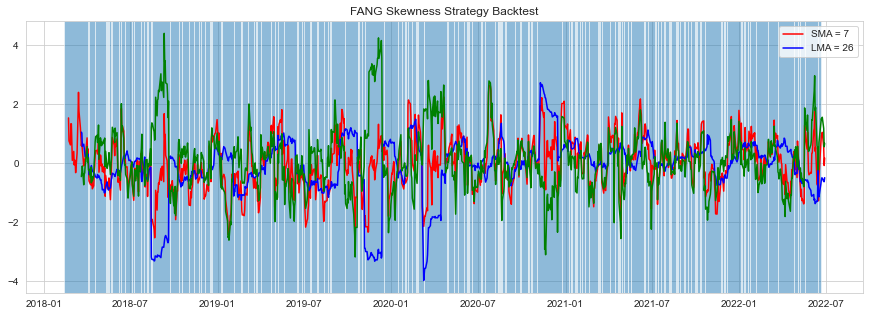

Last 2 Signals = 0.5489062642389883 0.6647842611232615
----------------------------------------------------------------
Performance plots for FANG
----------------------------------------------------------------


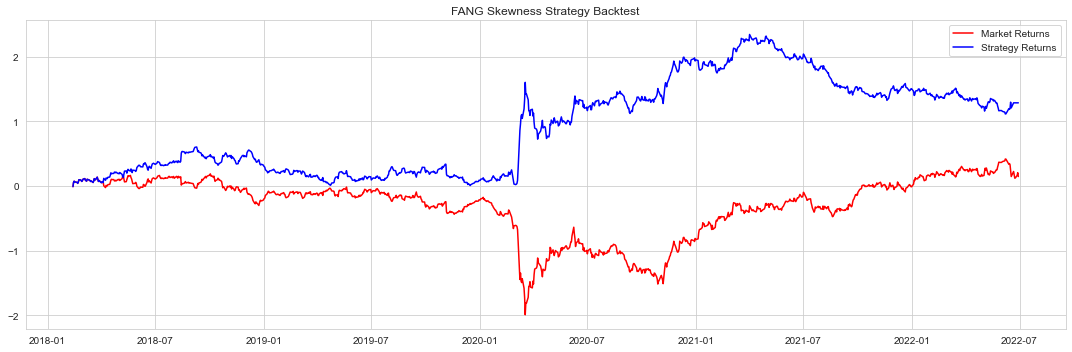

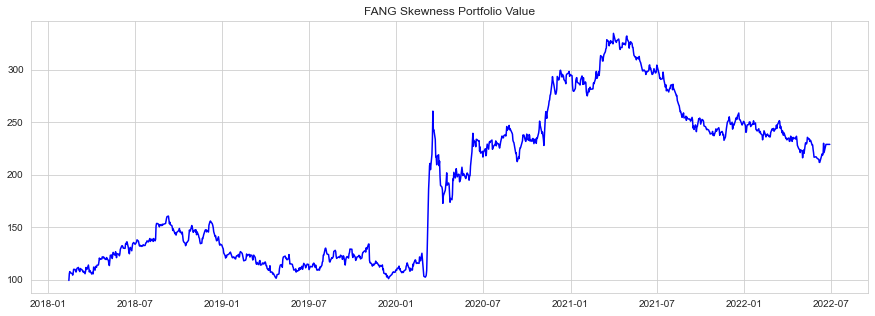

None
Daywise performance for FANG
----------------------------------------------------------------
Returns              0.147622
R_Mean               0.000134
R_Std_Dev            0.041464
R_Skew              -2.527158
R_Kurtosis          41.461551
R_Sharpe             0.051286
Str_Returns          1.288718
Str_R_Mean           0.001176
Str_R_Std_Dev        0.041426
Str_R_Skew           3.093752
Str_R_Kurtosis      41.469542
SharpeRatio          0.450584
TotalWins          561.000000
TotalLosses        534.000000
TotalTrades       1095.000000
HitRatio             0.510000
CAGR                 0.208345
MaxDrawdown          0.371614
dtype: float64
Tradewise performance for FANG
----------------------------------------------------------------
TotalWins                                                         101
TotalLosses                                                        94
TotalTrades                                                       195
HitRatio                                

Start date,2018-08-06
End date,2023-08-04
Total months,59
,Backtest
Annual return,-15.833%
Cumulative returns,-57.703%
Annual volatility,63.118%
Sharpe ratio,0.08
Calmar ratio,-0.17
Stability,0.11
Max drawdown,-93.313%


 MSC BACKTEST PERFORMANCE
======== BACKTEST STRATEGY RETURNS ========
Date
2018-08-07         NaN
2018-08-08   -0.008520
2018-08-09    0.065639
2018-08-10    0.018712
2018-08-11   -0.010257
                ...   
2021-08-09         NaN
2021-08-10         NaN
2021-08-11         NaN
2021-08-12         NaN
2021-08-13         NaN
Name: S_Return, Length: 1103, dtype: float64
======== BACKTEST BEGIN TEAR SHEET ========


Start date,2018-08-07
End date,2021-08-13
Total months,52
,Backtest
Annual return,9.692%
Cumulative returns,49.917%
Annual volatility,65.762%
Sharpe ratio,0.45
Calmar ratio,0.13
Stability,0.34
Max drawdown,-74.456%


======== BACKTEST END OF PERFROMANCE ========
Backtesting result for FANG
----------------------------------------------------------------
FILE CONTENT close_df
           Date    Open    High     Low   Close   Volume  Dividends  \
0    2018-02-12   95.58   99.37   95.58   99.01  1709900        0.0   
1    2018-02-13   98.34   99.36   97.87   98.17  1649400        0.0   
2    2018-02-14   99.00  104.93   97.95  104.83  2901600        0.0   
3    2018-02-15  105.82  106.90  103.77  106.81  2419800        0.0   
4    2018-02-16  105.93  108.17  105.36  105.72  1697000        0.0   
...         ...     ...     ...     ...     ...      ...        ...   
1098 2022-06-23  119.17  120.42  110.13  111.88  4647300        0.0   
1099 2022-06-24  114.05  118.05  110.77  112.32  8195200        0.0   
1100 2022-06-27  113.54  118.14  112.44  116.72  3281100        0.0   
1101 2022-06-28  120.81  123.32  118.04  121.79  3428400        0.0   
1102 2022-06-29  123.09  124.44  114.55  114.76  3422600  

/var/folders/fw/kcckd0xj57gb2qc72smx1m7r0000gn/T/ipykernel_25686/2861106589.py:148: RuntimeWarning: invalid value encountered in double_scalars
  d_perform['CAGR'] = ((1+self.data['Strategy_Return']).iloc[-1])**(365.25/self.n_days.days) -1


Most optimal cross-over pair is SMA:7, LMA:26


,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
21,nan,nan,nan,7.7,6.3,nan,nan,8.0,nan,3.1,-0.23,nan,nan,nan,nan,nan
22,nan,nan,nan,5.0,6.2,nan,nan,5.9,nan,nan,nan,nan,nan,nan,nan,nan
23,nan,nan,nan,5.4,7.4,0.16,nan,2.9,nan,1.8,nan,nan,nan,nan,nan,nan
24,nan,nan,nan,8.4,8.3,4.2,4.3,8.4,nan,2.1,nan,nan,nan,nan,nan,nan
25,nan,nan,nan,8.2,5.3,0.13,5.9,3.4,nan,6.5,-1.3,nan,nan,nan,nan,nan
26,nan,nan,nan,8.6,8.0,3.8,6.6,8.3,4.1,7.3,1.5,nan,nan,nan,nan,nan
27,nan,nan,nan,8.5,8.4,3.3,2.2,8.6,-1.3,3.4,5.1,nan,nan,nan,nan,nan
28,nan,nan,nan,nan,7.0,nan,3.1,4.0,1.8,0.033,5.5,nan,nan,nan,nan,nan
29,nan,nan,nan,-0.73,5.5,nan,4.8,6.3,-1.1,-2.3,1.3,nan,nan,nan,nan,nan
30,nan,nan,nan,nan,7.3,-0.43,-0.37,6.3,nan,0.082,nan,nan,nan,nan,nan,nan


,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
21,nan%,nan%,nan%,9.96%,-0.07%,nan%,nan%,13.09%,nan%,-8.05%,-54.11%,nan%,nan%,nan%,nan%,nan%
22,nan%,nan%,nan%,-6.02%,6.82%,nan%,nan%,0.94%,nan%,nan%,nan%,nan%,nan%,nan%,nan%,nan%
23,nan%,nan%,nan%,-4.58%,8.51%,-37.42%,nan%,-13.99%,nan%,-18.53%,nan%,nan%,nan%,nan%,nan%,nan%
24,nan%,nan%,nan%,16.23%,15.40%,-7.87%,-7.63%,17.17%,nan%,-11.58%,nan%,nan%,nan%,nan%,nan%,nan%
25,nan%,nan%,nan%,14.20%,-4.75%,-39.12%,2.00%,-9.67%,nan%,3.59%,-36.12%,nan%,nan%,nan%,nan%,nan%
26,nan%,nan%,nan%,20.83%,13.95%,-7.31%,6.97%,14.92%,-6.79%,12.24%,-14.87%,nan%,nan%,nan%,nan%,nan%
27,nan%,nan%,nan%,18.67%,18.02%,-8.53%,-10.17%,23.49%,-36.00%,-6.30%,-2.12%,nan%,nan%,nan%,nan%,nan%
28,nan%,nan%,nan%,nan%,6.49%,nan%,-8.87%,-8.07%,-11.28%,-20.68%,-0.42%,nan%,nan%,nan%,nan%,nan%
29,nan%,nan%,nan%,-48.06%,1.52%,nan%,-2.85%,1.58%,-31.46%,-44.26%,-13.70%,nan%,nan%,nan%,nan%,nan%
30,nan%,nan%,nan%,nan%,11.20%,-48.28%,-25.56%,4.00%,nan%,-18.87%,nan%,nan%,nan%,nan%,nan%,nan%


,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
21,200.00%,135.00%,132.00%,53.00%,62.00%,129.00%,133.00%,55.00%,114.00%,97.00%,100.00%,190.00%,332.00%,278.00%,351.00%,271.00%
22,211.00%,160.00%,231.00%,67.00%,90.00%,131.00%,129.00%,80.00%,131.00%,118.00%,150.00%,157.00%,294.00%,326.00%,294.00%,221.00%
23,250.00%,176.00%,186.00%,65.00%,63.00%,98.00%,110.00%,78.00%,168.00%,93.00%,182.00%,135.00%,289.00%,311.00%,302.00%,307.00%
24,219.00%,117.00%,102.00%,42.00%,49.00%,76.00%,78.00%,53.00%,120.00%,101.00%,128.00%,136.00%,232.00%,197.00%,313.00%,227.00%
25,204.00%,143.00%,129.00%,42.00%,65.00%,98.00%,83.00%,82.00%,118.00%,75.00%,121.00%,116.00%,215.00%,244.00%,235.00%,207.00%
26,196.00%,137.00%,136.00%,37.00%,58.00%,89.00%,83.00%,49.00%,86.00%,77.00%,101.00%,201.00%,189.00%,185.00%,232.00%,145.00%
27,233.00%,140.00%,121.00%,44.00%,52.00%,89.00%,101.00%,43.00%,121.00%,100.00%,89.00%,142.00%,167.00%,172.00%,308.00%,146.00%
28,194.00%,154.00%,160.00%,126.00%,69.00%,133.00%,91.00%,78.00%,104.00%,116.00%,84.00%,227.00%,191.00%,230.00%,355.00%,219.00%
29,210.00%,195.00%,124.00%,107.00%,89.00%,133.00%,90.00%,72.00%,123.00%,141.00%,105.00%,206.00%,190.00%,232.00%,288.00%,239.00%
30,214.00%,171.00%,123.00%,151.00%,75.00%,103.00%,116.00%,81.00%,176.00%,117.00%,139.00%,199.00%,202.00%,228.00%,300.00%,164.00%


,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
21,-0.78,-0.43,-0.36,0.18,-0.001,-0.53,-0.43,0.25,-0.41,-0.11,-0.34,-0.71,-0.93,-0.96,-1.3,-0.91
22,-0.81,-0.5,-0.81,-0.083,0.12,-0.52,-0.42,0.015,-0.44,-0.37,-0.49,-0.6,-1.1,-1.1,-0.99,-0.81
23,-1.1,-0.7,-0.66,-0.065,0.15,-0.3,-0.37,-0.17,-0.64,-0.21,-0.68,-0.52,-1.0,-1.3,-1.2,-1.2
24,-0.89,-0.45,-0.36,0.33,0.31,-0.11,-0.1,0.35,-0.42,-0.15,-0.45,-0.55,-0.93,-0.76,-1.2,-0.81
25,-0.8,-0.61,-0.49,0.28,-0.067,-0.31,0.032,-0.13,-0.44,0.058,-0.3,-0.41,-0.56,-0.9,-0.82,-0.87
26,-0.7,-0.53,-0.49,0.45,0.27,-0.099,0.12,0.29,-0.093,0.23,-0.18,-0.72,-0.36,-0.58,-0.69,-0.44
27,-0.82,-0.59,-0.44,0.39,0.38,-0.11,-0.13,0.53,-0.3,-0.086,-0.031,-0.47,-0.49,-0.49,-1.0,-0.41
28,-0.72,-0.65,-0.61,-0.37,0.11,-0.51,-0.12,-0.11,-0.14,-0.22,-0.0064,-0.75,-0.65,-0.8,-1.2,-0.76
29,-0.75,-0.81,-0.44,-0.34,0.024,-0.54,-0.042,0.025,-0.28,-0.32,-0.17,-0.67,-0.63,-0.81,-1.2,-1.1
30,-0.72,-0.63,-0.44,-0.5,0.21,-0.33,-0.25,0.065,-0.46,-0.21,-0.37,-0.63,-0.39,-0.8,-1.0,-0.49


Signal diagram for FANG
----------------------------------------------------------------


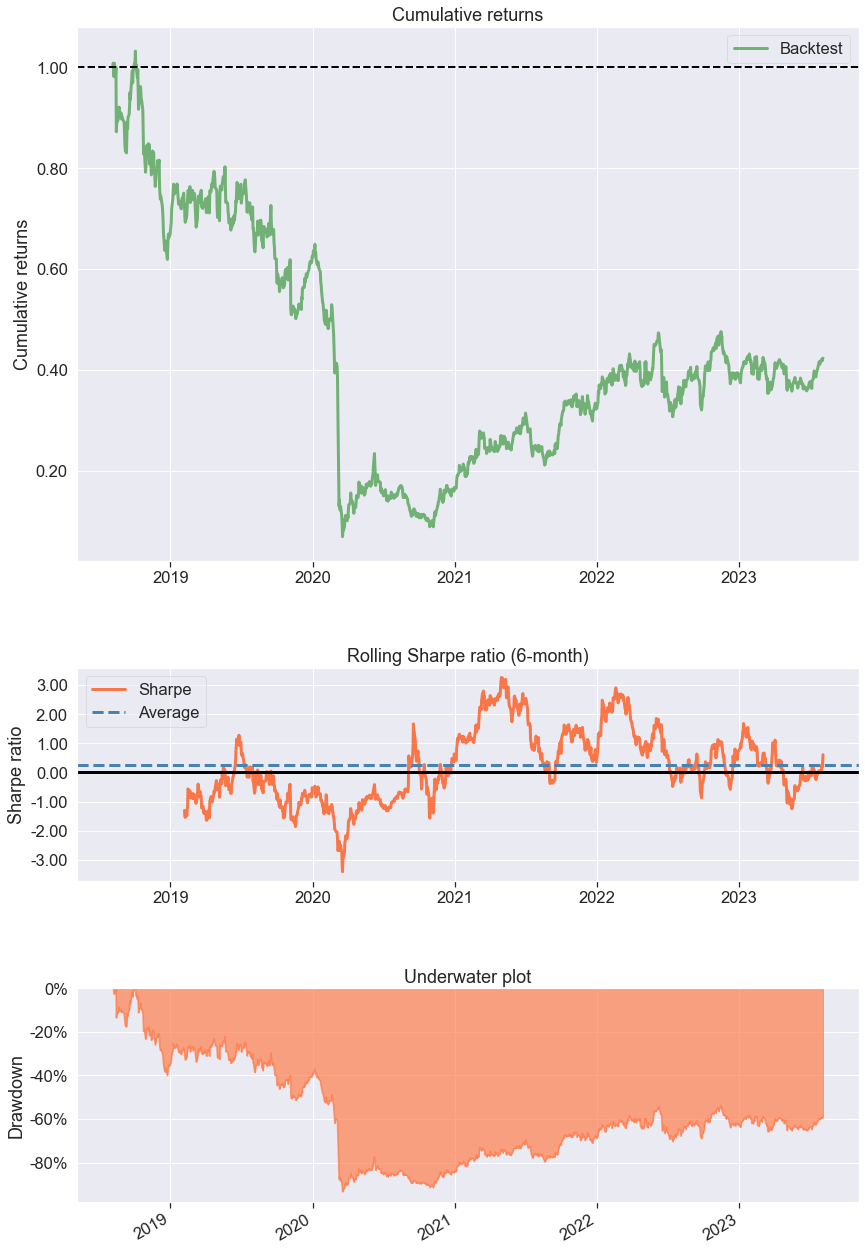

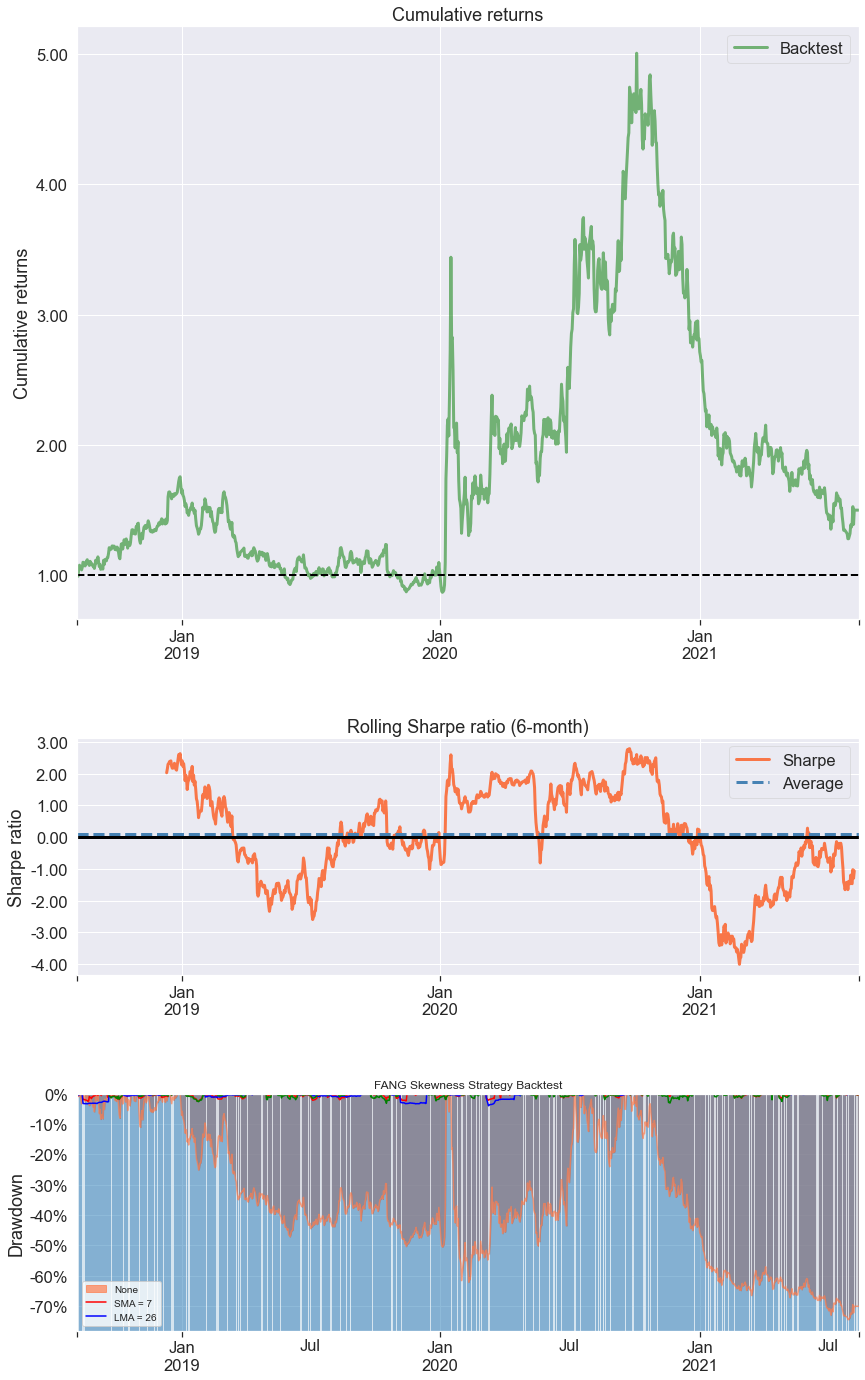

Last 2 Signals = 0.5489062642389883 0.6647842611232615
----------------------------------------------------------------
Performance plots for FANG
----------------------------------------------------------------


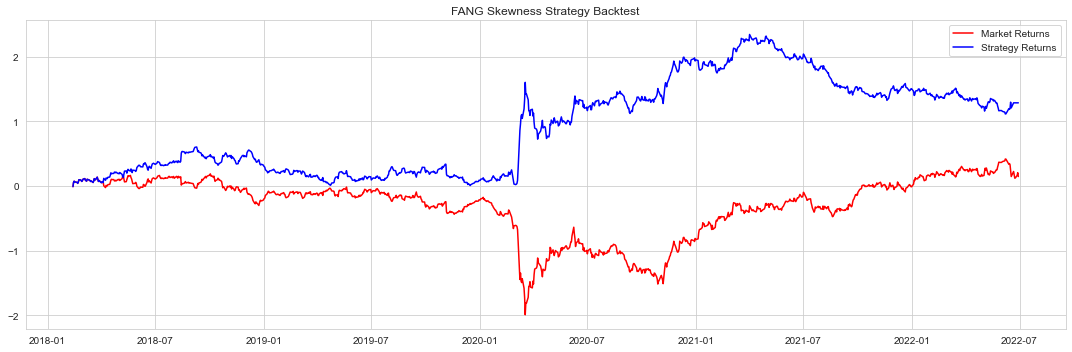

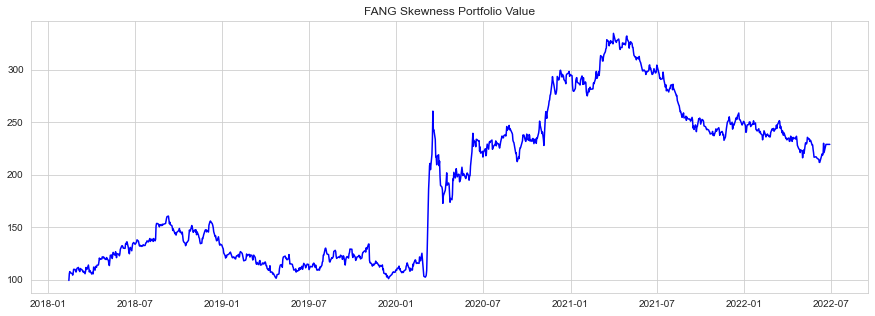

None
Daywise performance for FANG
----------------------------------------------------------------
Returns              0.147622
R_Mean               0.000134
R_Std_Dev            0.041464
R_Skew              -2.527158
R_Kurtosis          41.461551
R_Sharpe             0.051286
Str_Returns          1.288718
Str_R_Mean           0.001176
Str_R_Std_Dev        0.041426
Str_R_Skew           3.093752
Str_R_Kurtosis      41.469542
SharpeRatio          0.450584
TotalWins          561.000000
TotalLosses        534.000000
TotalTrades       1095.000000
HitRatio             0.510000
CAGR                 0.208345
MaxDrawdown          0.371614
dtype: float64
Tradewise performance for FANG
----------------------------------------------------------------
TotalWins                                                         101
TotalLosses                                                        94
TotalTrades                                                       195
HitRatio                                

Start date,2018-08-06
End date,2023-08-04
Total months,59
,Backtest
Annual return,-15.833%
Cumulative returns,-57.703%
Annual volatility,63.118%
Sharpe ratio,0.08
Calmar ratio,-0.17
Stability,0.11
Max drawdown,-93.313%


 NO MSC OOS END OF PERFROMANCE ========
 MSC OOS PERFORMANCE
Date
2022-08-07         NaN
2022-08-08   -0.008520
2022-08-09    0.065639
2022-08-10    0.018712
2022-08-11   -0.010257
                ...   
2025-08-09         NaN
2025-08-10         NaN
2025-08-11         NaN
2025-08-12         NaN
2025-08-13         NaN
Name: S_Return, Length: 1103, dtype: float64
======== OOS BEGIN TEAR SHEET ========


Start date,2022-08-07
End date,2025-08-13
Total months,52
,Backtest
Annual return,9.692%
Cumulative returns,49.917%
Annual volatility,65.762%
Sharpe ratio,0.45
Calmar ratio,0.13
Stability,0.34
Max drawdown,-74.456%


======== OOS END OF PERFROMANCE ========


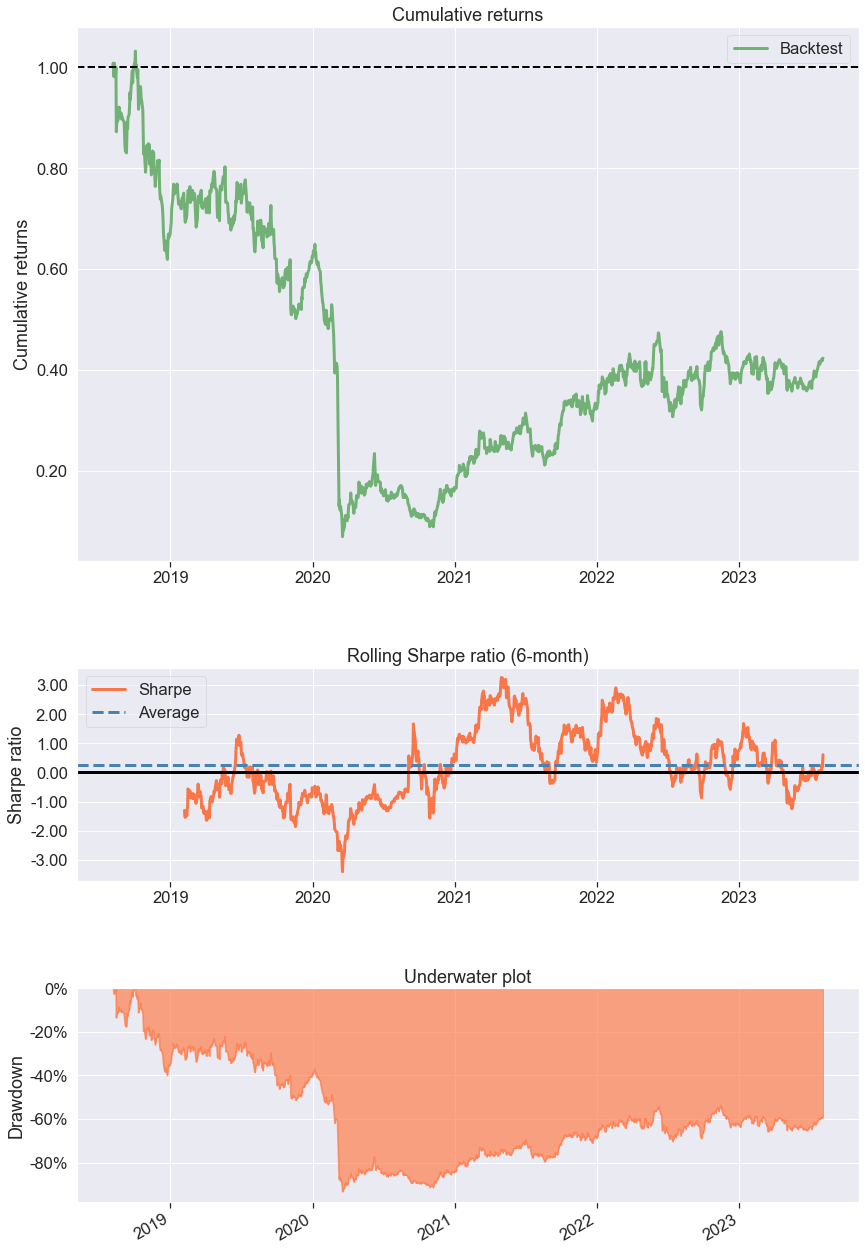

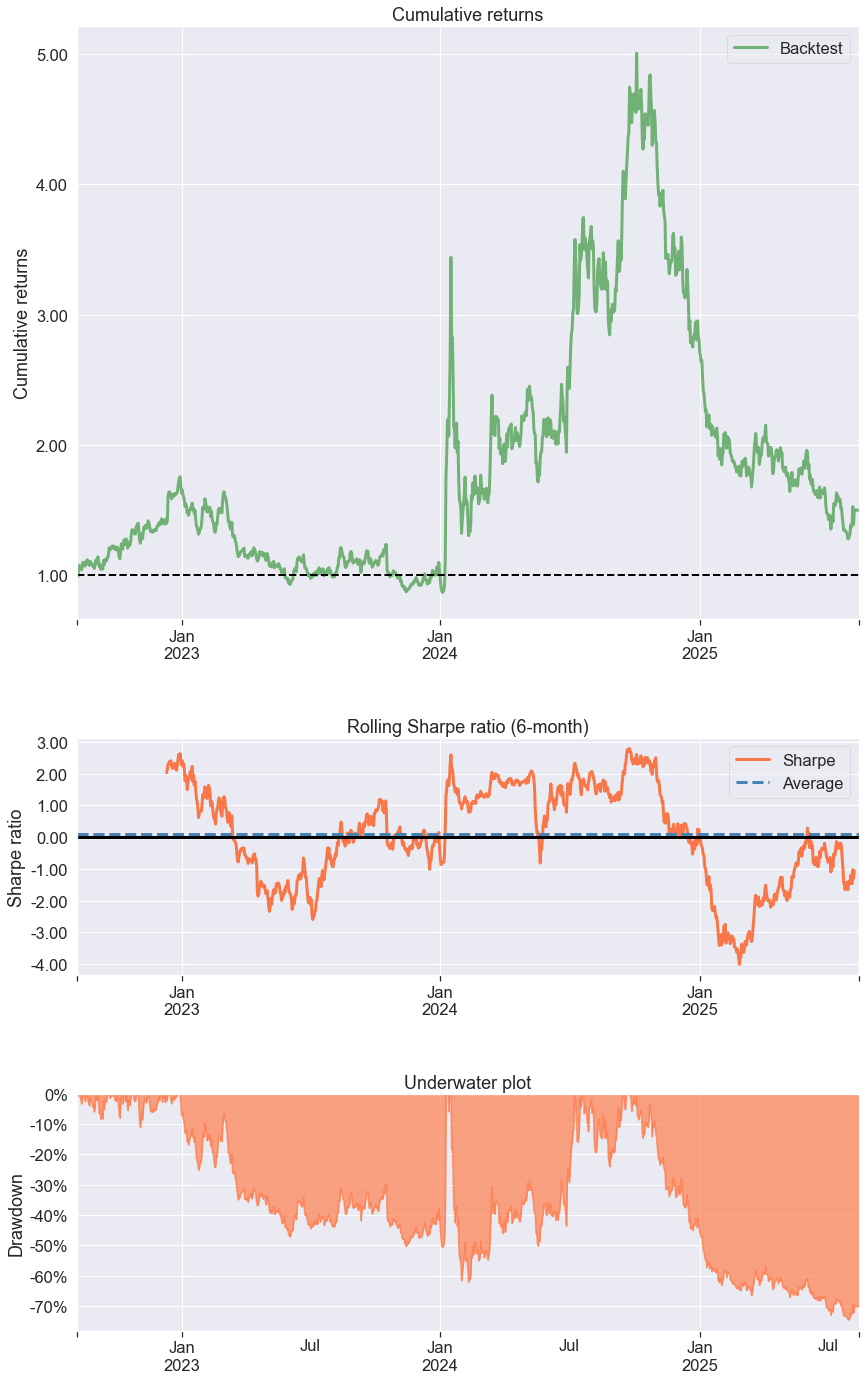

In [ ]:
TestAndDisplayResults("FANG","MSC",5,4,1)

#### print(LENGTH*"*")        
print('Fw tests complete...Time elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - start_time))
print(LENGTH*"*")



### PRINT RESULTS TO STREAM AND FILES <a name="print_results"></a>

In [ ]:
%time

results = pd.DataFrame({'Stock':stock_name, 'Strategy' : strats, 'IR': Information_Ratios, 'Signal': COMMANDS, 'MDD': MDDs, 'R_Skew': R_Skews, 'Delta Skew': DELTA_SKEWs, 'R_Std_Dev' :R_Std_Devs, 'Str_R_Skew': Str_R_Skews, 'R_Sharpe': R_Sharpes, 'Str_Sharpe': sharpes, 'Returns ':returns, 'Str_Returns':str_returns,  'NHR':nhrs,
                        'SumLast10Signals':Last_signal_Sum10, 'SMAs':SMAs, 'LMAs':LMAs, 'TP': AWRs, 'SL': ALRs, 'KellyR': Kellys, 'W:L': WinOverLoss, 'SharpeOverMDD': SharpeOverMDD   })

from datetime import date, timedelta

print('MSC Strategy applied to below assets with following performance:')
print(LENGTH * '-')

filename1 = f"01_MR-{END_DATE}_BackTest.csv"

# sorted = results[(results['Delta Skew'] > 0.0) ].sort_values(by=[ 'Delta Skew', 'IR', 'R_Skew', 'R_Std_Dev'], ascending=[False,False,False,True]).reset_index(drop=True)
#sorted = results[(results['Delta Skew'] > 0.0) ].sort_values(by=[ 'Delta Skew'], ascending=[False]).reset_index(drop=True)


sorted = results[['Stock','IR','Str_Sharpe','MDD','Str_Returns']].sort_values(by=[ 'IR'], ascending=[False]).head(20).reset_index(drop=True)

#sorted = results[(results['R_Std_Dev'] < 0.05) & (results['Delta Skew'] > 0.0)].sort_values(by=[ 'Signal', 'IR', 'R_Skew', 'R_Std_Dev'], ascending=[False,False,False,True]).reset_index(drop=True)
#sorted = results[(results['Str_R_Skew'] > 0.14)].sort_values(by=[ 'Signal', 'Delta Skew'], ascending=[False,False]).reset_index(drop=True)
#sorted = results.sort_values(by=['IR'], ascending=[False]).reset_index(drop=True)
#sorted = results.sort_values(by=['Delta Skew'], ascending=[False]).reset_index(drop=True)
#sorted = results.sort_values(by=[ 'MDD', 'Str_R_Skew'], ascending=[True,True]).reset_index(drop=True)

print(sorted)
os.chdir(working_dir+"MR_Portfolios")
sorted.to_csv(filename1)

print(LENGTH * '-')
print(f"Data written to {filename1}")
print(LENGTH * '%')
sorted = results.sort_values(by=[ 'Str_Returns'], ascending=[False]).reset_index(drop=True)
TR_TOP_TEN = sorted.Stock

print(LENGTH*"*")
#print('Backtests complete...Time elapsed (hh:mm:ss.ms) {}'.format(datetime.today() - start_time))
print(LENGTH*"*")



%time

filename1 = f"01_MR-{END_DATE}_FwTest.csv"

# SORTING VALUES AGAINST A COLUMN VALUE LIMIT

sorted2 = sorted[ (sorted['IR'] > 1) &
                  (sorted['R_Std_Dev'] < 0.027) &
                  (sorted['Str_Sharpe'] > 1) &
                  (sorted['Str_R_Skew'] > 0.0) &
                  (sorted['Delta Skew'] > 0.0) &
                  (sorted['W:L'] > 1) &
                  (sorted['Signal'] != 'HOLD') &
                  (sorted['Signal'] != 'SELL') &
                  (sorted['SharpeOverMDD'] > 1) &
                  (sorted['MDD'] < 0.15) &
                  #(sorted['Signal'] != 'STRONG SELL')].sort_values(by=[ 'SharpeOverMDD'], ascending=[False]).reset_index(drop=True)
                  (sorted['Signal'] != 'STRONG SELL')].sort_values(by=[ 'IR'], ascending=[False]).reset_index(drop=True)

#sorted = results.sort_values(by=[ 'Signal', 'Delta Skew'], ascending=[False,False]).reset_index(drop=True)
#sorted = results.sort_values(by=[ 'MDD', 'Delta Skew'], ascending=[True,False]).reset_index(drop=True)


print(sorted2)
BIST_Top_22 = sorted2.Stock

os.chdir(working_dir+"MR_Portfolios")
sorted2.to_csv(filename1)
print(LENGTH * '-')
print(f"Data written to {filename1}")
print(LENGTH * '%')

# with open(writePath, 'a') as f:
#     dfAsString = df.to_string(header=False, index=False)
#     f.write(dfAsString)



CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 3.1 µs
MSC Strategy applied to below assets with following performance:
----------------------------------------------------------------
  Stock      IR  Str_Sharpe   MDD  Str_Returns
0  FANG  1.1411      0.4506  0.37       1.2887
1  FANG  1.1411      0.4506  0.37       1.2887
----------------------------------------------------------------
Data written to 01_MR-2023-08-06 11:54:43.400046_BackTest.csv
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
****************************************************************
****************************************************************
CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 1.91 µs
Empty DataFrame
Columns: [Stock, Strategy, IR, Signal, MDD, R_Skew, Delta Skew, R_Std_Dev, Str_R_Skew, R_Sharpe, Str_Sharpe, Returns , Str_Returns, NHR, SumLast10Signals, SMAs, LMAs, TP, SL, KellyR, W:L, SharpeOverMDD]
Index: []

[0 rows x 22 columns]
------------------------

In [ ]:
# import datetime
# print(LENGTH*"*")
# print('Fw testing complete...Time elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - start_time))
# print(LENGTH*"*")
# start_time = datetime.now()

In [ ]:
# ENUMARATION OF ALL CSV IN A DIRECTORY

# from collections import defaultdict
# from itertools import count
# from functools import partial

# label_to_number = defaultdict(partial(next, count(1)))
# [(label_to_number[label], label) for label in stock_list]

# LISTING OF ALL CSV IN A DIRECTORY

# os.chdir(f"/Users/alperulku/EPAT-99-FINAL PROJECT/EPAT PROJECT WORK/BIST100")
# import pandas as pd
# import os
# all_csv = [file_name for file_name in os.listdir(os.getcwd()) if '.csv' in file_name]
# all_csv

### MY CURRENT PORTFOLIO PERFORMANCE <a name="my_pf_perf"></a>

In [ ]:
'''
UTILITY U=003 : SET_PORTFOLIO_PROPERTIES
--------------------------------------------
- SETS desired assets names
- SETS number of shares for each asset
- SETS extra cash value
- PRINTS these as a table
'''
import pandas as pd
Portfolio_Assets = [ "TSLA", "AMZN", "GOOGL" ]
#Portfolio_Assets = stock_list
#Portfolio_Shares = [  2846, 12.363, 2000]
#Cash_Plus_MFs = 196000 # cash + fon + temettü
#new_df = pd.Series(Portfolio_Shares, Portfolio_Assets)
#print(new_df)


' \nUTILITY U=003 : SET_PORTFOLIO_PROPERTIES\n--------------------------------------------\n- SETS desired assets names\n- SETS number of shares for each asset\n- SETS extra cash value\n- PRINTS these as a table\n'

In [ ]:
'''
UTILITY U=001 : CSV_MERGER
--------------------------------------------
- READS desired assets from csv files
- APPENDS the 'close' columns required in a single df name `li`
- DROPS NA rows
'''
import pandas as pd
li = pd.DataFrame() # my real portfolio dataframe

rets = pd.DataFrame()

names = []
count = len(Portfolio_Assets)

os.chdir(working_dir+"BIST100")
#for file in sorted2.Stock:
for file in Portfolio_Assets:
    df = pd.read_csv(f"{file}.csv", index_col='Date', parse_dates=True, keep_date_col = True, infer_datetime_format=True, dayfirst=True)
    li = pd.concat([li,df['Close']],axis=1) #, ignore_index=False)
    st_name = file.split('.',maxsplit = 1)
    names.append(st_name[0])

li.columns = names
li = li.dropna()









" \nUTILITY U=001 : CSV_MERGER\n--------------------------------------------\n- READS desired assets from csv files\n- APPENDS the 'close' columns required in a single df name `li` \n- DROPS NA rows\n"

In [ ]:
names

['TSLA', 'AMZN', 'GOOGL']

In [ ]:
li

,TSLA,AMZN,GOOGL
2018-02-12,21.05,69.31,52.73
2018-02-13,21.58,70.73,52.71
2018-02-14,21.49,72.55,53.63
2018-02-15,22.27,73.09,54.57
2018-02-16,22.37,72.43,54.78
...,...,...,...
2023-07-11,269.79,128.78,117.14
2023-07-12,271.99,130.80,118.93
2023-07-13,277.90,134.30,124.54
2023-07-14,281.38,134.68,125.42


In [ ]:
li = li.rename_axis(index="Date")
li


,TSLA,AMZN,GOOGL
Date,,,
2018-02-12,21.05,69.31,52.73
2018-02-13,21.58,70.73,52.71
2018-02-14,21.49,72.55,53.63
2018-02-15,22.27,73.09,54.57
2018-02-16,22.37,72.43,54.78
...,...,...,...
2023-07-11,269.79,128.78,117.14
2023-07-12,271.99,130.80,118.93
2023-07-13,277.90,134.30,124.54


In [ ]:
sorted = li.sort_values(by=['Date'], ascending=[False])
sorted.to_csv('BIST_22.csv')
sorted

,TSLA,AMZN,GOOGL
Date,,,
2023-07-17,290.38,133.56,124.65
2023-07-14,281.38,134.68,125.42
2023-07-13,277.90,134.30,124.54
2023-07-12,271.99,130.80,118.93
2023-07-11,269.79,128.78,117.14
...,...,...,...
2018-02-16,22.37,72.43,54.78
2018-02-15,22.27,73.09,54.57
2018-02-14,21.49,72.55,53.63


In [ ]:
# '''
# UTILITY U=002 : PORTFOLIO_CALCULATOR
# --------------------------------------------
# - READS column of individual assets
# - CALCULATES the portfolio value as `li[Portfolio]` appended to df `li`
# - CALCULATES daily log returns for every column of li and writes to `rets`
# - CALCULATES daily PF Index and writes to `li[Portfolio_Index] and normal daily returns and writes to `li[PF_Returns]`
# - PRINTS the tear sheet of varios statistics
# '''
# import matplotlib.pyplot as plt
# import pyfolio as pf
# import numpy as np
# ADD = 0
# for i in np.arange(0,count):
#     if names[i] == "GC=F" or names[i] == "^DJI":
#         ADD +=  li[f"{names[i]}"] * li["TRY=X"] * Portfolio_Shares[i]
#     else:
#         ADD +=  li[f"{names[i]}"] * Portfolio_Shares[i]

# ADD += Cash_Plus_MFs # FONLARI EKLEDIK
# #li = pd.concat([li, ADD], axis=1, ignore_index=False)
# li['Portfolio'] = ADD
# print(f"Stocks selected = {names}")
# print(f"Number of stocks selected = {len(names)}")

# for file in li.columns:
#     a = np.log(li[f"{file}"] / (li[f"{file}"].shift(1)))
#     rets[f"{file}"]= a

# print(" My Portfolio", li.round(2).tail(30))

# print(" Returns", rets.round(5).tail(30))

# plt.plot(li.Portfolio.tail(99))

# # li['Portfolio'] = ADD # cash added
# li['Index'] = li['Portfolio'] / li['Portfolio'].iloc[0]
# li['PF_Returns'] = ((li['Portfolio']-li['Portfolio'].shift(1)) / li['Portfolio'].shift(1)).fillna(method="ffill").round(6)
# li.dropna()

# print(f"********* PORTFOLIO TEARSHEET *************** ")
# pf.create_simple_tear_sheet(li['PF_Returns'].dropna())
# print("********* end of TEARSHEET **************\n")


In [ ]:
'''
UTILITY U=003A : SET_PORTFOLIO_PROPERTIES
--------------------------------------------
- SETS desired assets names
- SETS number of shares for each asset
- SETS extra cash value
- EXTRACTS selected assets from 22 MFs
- PRINTS these as a table
'''

Portfolio_Assets = [ "TSLA"]
Portfolio_Shares = [  607]

Ideal_Assets = ["TGE", "AES", "NNF", "IOG" ]
Ideal_Weights = [ 0.14625, 0.40809, 0.3908, 0.05487 ]


Cash_Plus_MFs = 0
pf = li.loc[:,Portfolio_Assets]
pf['PF_Value'] = np.round(np.dot(pf,Portfolio_Shares),2)  # PF_VALUE = dot product of shares and their prices !!!!
new_df = pd.Series(Portfolio_Shares, Portfolio_Assets)
print(new_df)

' \nUTILITY U=003A : SET_PORTFOLIO_PROPERTIES\n--------------------------------------------\n- SETS desired assets names\n- SETS number of shares for each asset\n- SETS extra cash value\n- EXTRACTS selected assets from 22 MFs\n- PRINTS these as a table\n'

TSLA    607
dtype: int64


In [ ]:
InitialPrices = pf.iloc[0,:]
print(f"\n Initial prices: \n{InitialPrices} \n")


 Initial prices: 
TSLA           21.05
PF_Value    12777.35
Name: 2018-02-12 00:00:00, dtype: float64 



In [ ]:
pf.tail(20)

,TSLA,PF_Value
Date,,
2023-06-16 00:00:00,260.54,158147.78
2023-06-20 00:00:00,274.45,166591.15
2023-06-21 00:00:00,259.46,157492.22
2023-06-22 00:00:00,264.61,160618.27
2023-06-23 00:00:00,256.60,155756.20
2023-06-26 00:00:00,241.05,146317.35
2023-06-27 00:00:00,250.21,151877.47
2023-06-28 00:00:00,256.24,155537.68
2023-06-29 00:00:00,257.50,156302.50


In [ ]:
'''
UTILITY U=012 : SHARPE_CALCULATOR
--------------------------------------------
- CALCULATES mean return, std dev and sharpe for a PF

'''

pf['Returns'] = (pf.PF_Value / pf.PF_Value.shift(1))-1
MeanReturn =  np.round(100*pf.Returns.mean(),3)
print(f"Mean Strategy Return = % {MeanReturn}")
StandardDeviation =  np.round( pf.Returns.std()*100,3)
print(f"Std dev of Returns = % {StandardDeviation}")

Rf_daily = 0.25/252
Sharpe = np.round(((MeanReturn - Rf_daily) / StandardDeviation)*np.sqrt(252),5)
print(f"Sharpe = {Sharpe}")
pf


'\nUTILITY U=012 : SHARPE_CALCULATOR\n--------------------------------------------\n- CALCULATES mean return, std dev and sharpe for a PF \n\n'

Mean Strategy Return = % 0.277
Std dev of Returns = % 4.113
Sharpe = 1.06528


,TSLA,PF_Value,Returns
Date,,,
2018-02-12,21.05,12777.35,NaN
2018-02-13,21.58,13099.06,0.025178
2018-02-14,21.49,13044.43,-0.004171
2018-02-15,22.27,13517.89,0.036296
2018-02-16,22.37,13578.59,0.004490
...,...,...,...
2023-07-11,269.79,163762.53,0.000668
2023-07-12,271.99,165097.93,0.008154
2023-07-13,277.90,168685.30,0.021729


### PORTFOLIO TEARSHEET  <a name="pf_tearsheet"></a>

********* PORTFOLIO TEARSHEET *************** 


Start date,2018-02-12
End date,2023-07-17
Total months,65
,Backtest
Annual return,62.334%
Cumulative returns,1279.477%
Annual volatility,65.295%
Sharpe ratio,1.07
Calmar ratio,0.85
Stability,0.77
Max drawdown,-73.632%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,73.63,2021-11-04,2023-01-03,NaT,NaN
1,60.63,2020-02-19,2020-03-18,2020-06-08,79
2,52.85,2018-08-07,2019-06-03,2019-12-16,355
3,36.24,2021-01-26,2021-03-08,2021-10-21,193
4,33.74,2020-08-31,2020-09-08,2020-11-19,59


********* end of TEARSHEET **************



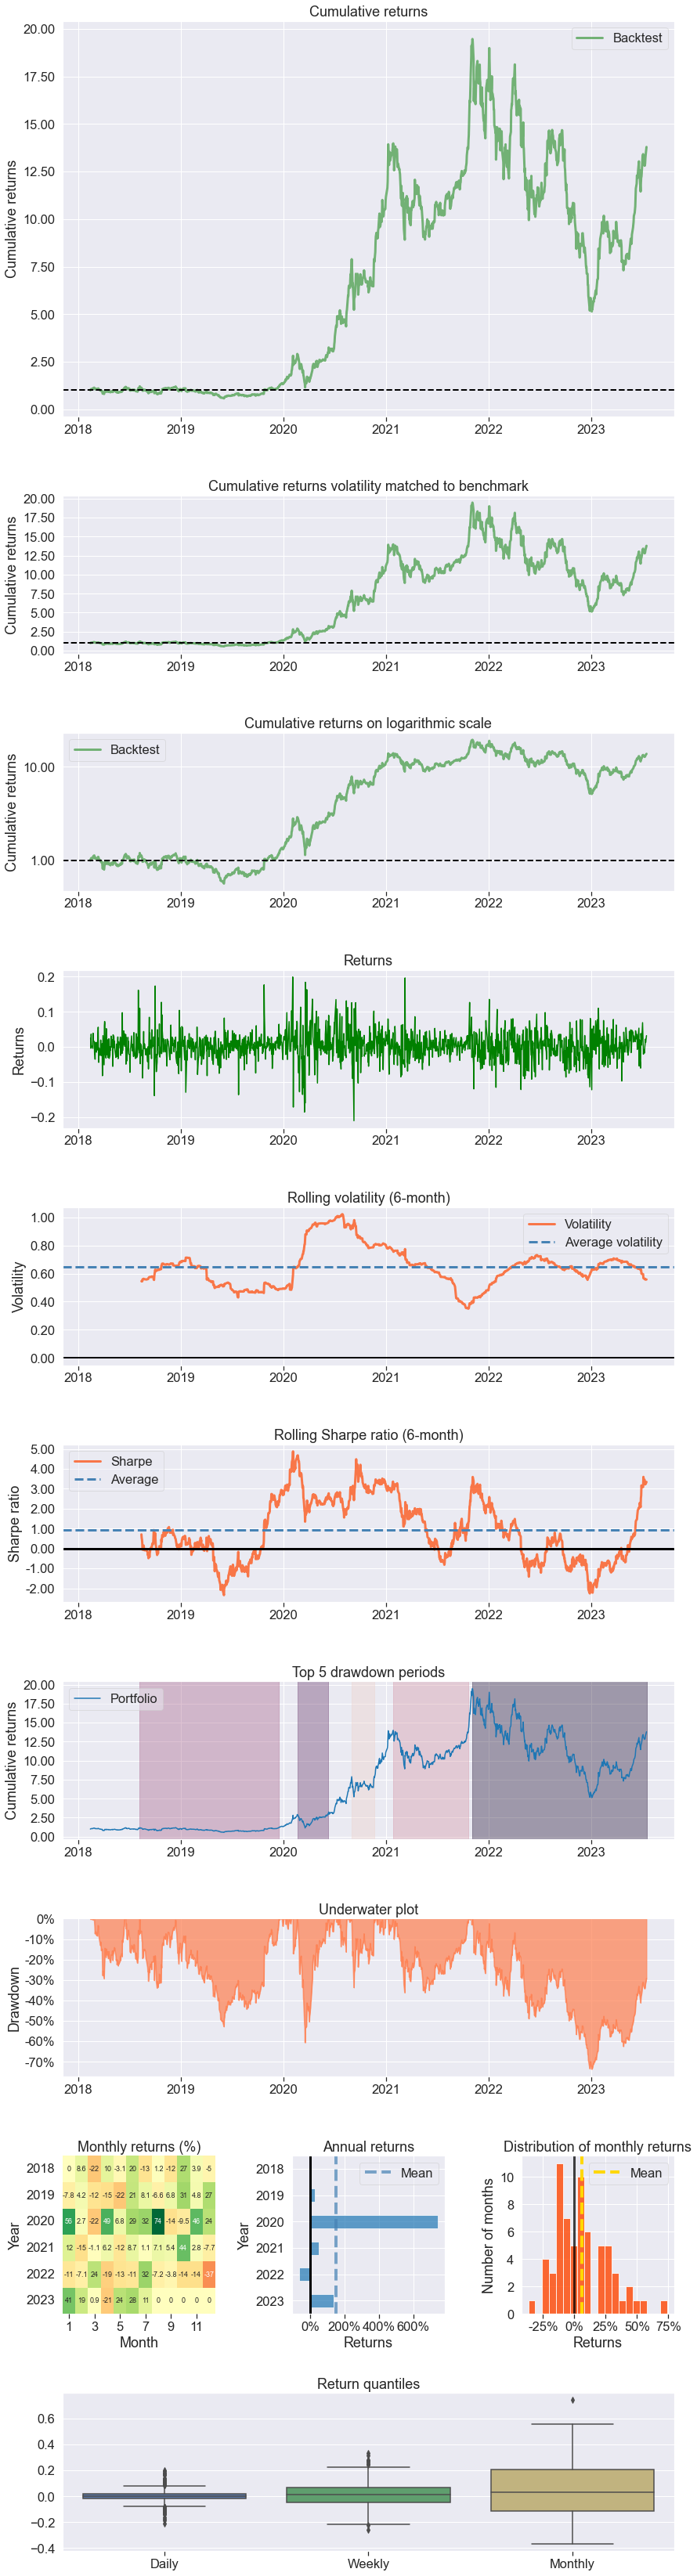

In [ ]:
import pyfolio as py
print(f"********* PORTFOLIO TEARSHEET *************** ")
py.create_returns_tear_sheet(pf['Returns'])
print("********* end of TEARSHEET **************\n")

In [ ]:
'''
UTILITY U=016 : OPTIMUM PF_MARKOVITZ PART 1
--------------------------------------------
- FINDS daily percentage change of 22 assets of last 66 days as `rets`
- FORMS the mr matrix with returns, dropping 1st NA row
- CALCULATES mean returns as r and covariance as C
- PRINTS individual asset returns and std deviations
'''

rets = li.pct_change()
rets
#li.set_index('Date', inplace=True)
days = 66
mr = rets
mr.index = pd.to_datetime(li.index)
mr = mr[-days:].dropna()
#mr = mr.resample('1M').mean()

#mr.drop(mr.columns[[-1, -2, -3]], axis = 1, inplace = True)
#mr.round(5).tail(20)
mr

symbols = mr.columns
n= len(symbols)
symbols, n
return_data = mr.T # form the return matrix as transposed
return_data

# compute sum of daily returns and covariance matrix
r = np.asarray(np.sum(return_data, axis=1))
C = np.asmatrix(np.cov(return_data))


print ("------- RETURNS OF LAST 3 MOS and STD DEVIATIONS ---------------")
for j in range(len(symbols)):
    print (f"{symbols[j]}\t","Returns={0:.1%}\t".format(r[j]), "Stdev={0:.1%}".format(C[j,j]**0.5))




'\nUTILITY U=016 : OPTIMUM PF_MARKOVITZ PART 1\n--------------------------------------------\n- FINDS daily percentage change of 22 assets of last 66 days as `rets` \n- FORMS the mr matrix with returns, dropping 1st NA row\n- CALCULATES mean returns as r and covariance as C\n- PRINTS individual asset returns and std deviations\n'

,TSLA,AMZN,GOOGL
Date,,,
2018-02-12,NaN,NaN,NaN
2018-02-13,0.025178,0.020488,-0.000379
2018-02-14,-0.004171,0.025732,0.017454
2018-02-15,0.036296,0.007443,0.017528
2018-02-16,0.004490,-0.009030,0.003848
...,...,...,...
2023-07-11,0.000668,0.012979,0.005925
2023-07-12,0.008154,0.015686,0.015281
2023-07-13,0.021729,0.026758,0.047171


,TSLA,AMZN,GOOGL
Date,,,
2023-04-12,-0.033460,-0.020917,-0.006739
2023-04-13,0.029689,0.046714,0.026663
2023-04-14,-0.004841,0.001074,0.013404
2023-04-17,0.011027,0.002244,-0.026637
2023-04-18,-0.014596,-0.004283,-0.013872
...,...,...,...
2023-07-11,0.000668,0.012979,0.005925
2023-07-12,0.008154,0.015686,0.015281
2023-07-13,0.021729,0.026758,0.047171


(Index(['TSLA', 'AMZN', 'GOOGL'], dtype='object'), 3)

Date,2023-04-12,2023-04-13,2023-04-14,2023-04-17,2023-04-18,2023-04-19,2023-04-20,2023-04-21,2023-04-24,2023-04-25,...,2023-07-03,2023-07-05,2023-07-06,2023-07-07,2023-07-10,2023-07-11,2023-07-12,2023-07-13,2023-07-14,2023-07-17
TSLA,-0.033460,0.029689,-0.004841,0.011027,-0.014596,-0.020183,-0.097458,0.012823,-0.015326,-0.011566,...,0.068954,0.009506,-0.021028,-0.007630,-0.017564,0.000668,0.008154,0.021729,0.012522,0.031985
AMZN,-0.020917,0.046714,0.001074,0.002244,-0.004283,0.019550,-0.004698,0.030344,-0.007012,-0.034272,...,-0.001074,0.001229,-0.015493,0.011063,-0.020419,0.012979,0.015686,0.026758,0.002829,-0.008316
GOOGL,-0.006739,0.026663,0.013404,-0.026637,-0.013872,-0.003062,0.010655,0.001140,0.005313,-0.020006,...,0.001671,0.015430,-0.013470,-0.005245,-0.025360,0.005925,0.015281,0.047171,0.007066,-0.006139


------- RETURNS OF LAST 3 MOS and STD DEVIATIONS ---------------
TSLA	 Returns=47.1%	 Stdev=3.0%
AMZN	 Returns=30.3%	 Stdev=1.9%
GOOGL	 Returns=17.8%	 Stdev=1.7%


In [ ]:
'''
UTILITY U=016 : OPTIMUM PF_MARKOVITZ PART 2
--------------------------------------------
- CALLS cvxpy package for solver
- CALCULATES risk matrix
'''


import cvxpy as cp
n = len(symbols)
x = cp.Variable(n)
#x = [ .1,  0.2 , 0.7]

ret = r.T*x
risk = cp.quad_form(x, C)
#std_dev = np.sqrt(risk.value)



'\nUTILITY U=016 : OPTIMUM PF_MARKOVITZ PART 2\n--------------------------------------------\n- CALLS cvxpy package for solver\n- CALCULATES risk matrix\n'

/opt/homebrew/lib/python3.9/site-packages/cvxpy/expressions/expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  warnings.warn(msg, UserWarning)


In [ ]:
'''
UTILITY U=016 : OPTIMUM PF_MARKOVITZ PART 3
--------------------------------------------
- GETS prob as input problem
- SOLVES the minimization problem
'''


# req_return = 0.57
# arrange so that std dev is % 1.618
#prob = cp.Problem(cp.Minimize(risk), [cp.sum(x) == 1.0, ret >= req_return, x >= 0])
# prob = cp.Problem(cp.Minimize(risk), [cp.sum(x) == 1.0, ret >= req_return, x >= 0])

# prob.solve()
# print (60*"-")
# print ("Optimal portfolio")
# print (60*"-")
# print (f"{symbols}")
# print (f"Weights = {x.value}\n")
# print (60*"-")
# print ("Exp ret =  {0:.1%}".format(ret.value))
# print ("Standard deviation =  {0:.6%}".format(risk.value**0.5))
# print (60*"-")

# symbols
# index = x.value>=0.001
# Portfolio_Weights = x.value[index].round(3)
# Portfolio_Assets = symbols[index]
# Portfolio_Amounts = Portfolio_Weights*30000

# [int(num) for num in Portfolio_Amounts]


# BEST_PF = pd.Series(Portfolio_Weights*100, Portfolio_Assets)
# print("% weights of BEST PF")
# print (60*"-")
# BEST_PF

'\nUTILITY U=016 : OPTIMUM PF_MARKOVITZ PART 3\n--------------------------------------------\n- GETS prob as input problem\n- SOLVES the minimization problem\n'

### AN ALTERNATIVE OPTIMUM PORTFOLIO <a name="alternative_pf"></a>

In [ ]:
# Portfolio_Weights
# Portfolio_Assets
# Portfolio_Amounts
# pd.Series(np.round(Portfolio_Amounts,0), Portfolio_Assets)


### OPTIONS TRADING CALCULATIONS <a name="options"></a>

#### Bull Call Spread Payoff

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# For making an attractive and informative statistical graph
plt.style.use('seaborn-darkgrid')

In [ ]:
def call_payoff(sT, strike_price, premium):
    return np.where(sT > strike_price, sT - strike_price, 0) - premium

In [ ]:
# Infosys stock price
factor = 1
spot_price = 900/factor

# Long call
strike_price_long_call = 920/factor


premium_long_call = 15/factor


# Short call
strike_price_short_call = 940/factor
premium_short_call = 10/factor

# Stock price range at expiration of the call
sT = np.arange(0.95*spot_price, 1.1*spot_price, 1)

Text(0.5, 0, 'Infosys Stock Price')

Text(0, 0.5, 'Profit and loss')

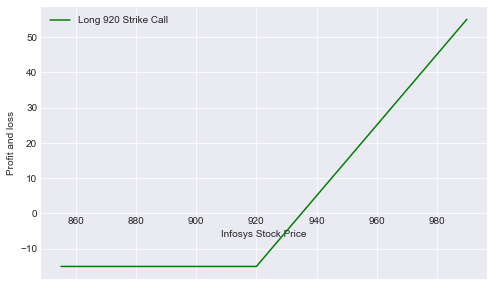

In [ ]:
payoff_long_call = call_payoff(sT, strike_price_long_call, premium_long_call)
# Plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.spines['bottom'].set_position('zero')
ax.plot(sT, payoff_long_call, label='Long 920 Strike Call', color='g')
plt.xlabel('Infosys Stock Price')
plt.ylabel('Profit and loss')
plt.legend()
plt.show()

Text(0.5, 0, 'Infosys Stock Price')

Text(0, 0.5, 'Profit and loss')

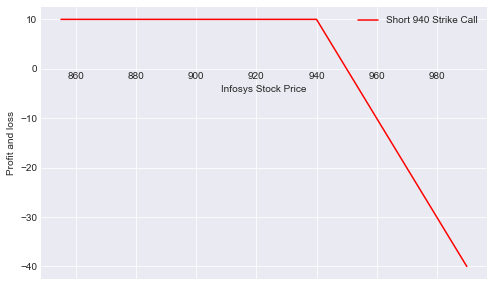

In [ ]:
payoff_short_call = call_payoff(
    sT, strike_price_short_call, premium_short_call) * -1.0

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.spines['bottom'].set_position('zero')
ax.plot(sT, payoff_short_call, label='Short 940 Strike Call', color='r')
plt.xlabel('Infosys Stock Price')
plt.ylabel('Profit and loss')
plt.legend()
plt.show()

Max Profit: 15.0
Max Loss: -5.0


Text(0.5, 0, 'Infosys Stock Price')

Text(0, 0.5, 'Profit and loss')

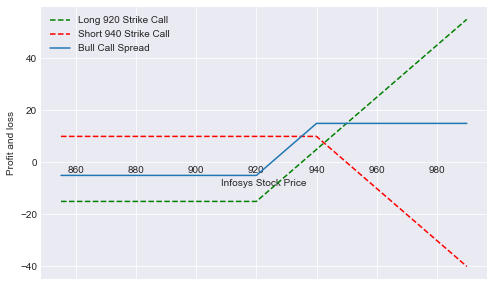

In [ ]:
payoff_bull_call_spread = payoff_long_call + payoff_short_call

print("Max Profit:", max(payoff_bull_call_spread))
print("Max Loss:", min(payoff_bull_call_spread))

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.spines['bottom'].set_position('zero')
ax.plot(sT, payoff_long_call, '--', label='Long 920 Strike Call', color='g')
ax.plot(sT, payoff_short_call, '--', label='Short 940 Strike Call ', color='r')
ax.plot(sT, payoff_bull_call_spread, label='Bull Call Spread')
plt.xlabel('Infosys Stock Price')
plt.ylabel('Profit and loss')
plt.legend()
plt.show()

#### Bear put spread

In [ ]:
def put_payoff(sT, strike_price, premium):
    return np.where(sT < strike_price, strike_price - sT, 0) - premium

In [ ]:
# Infosys stock price
spot_price = 900

# Long put
strike_price_long_put = 880
premium_long_put = 15

# Short put
strike_price_short_put = 860
premium_short_put = 10

# Stock price range at expiration of the put
sT = np.arange(0.9*spot_price,1.05*spot_price,1)

Text(0.5, 0, 'Infosys Stock Price')

Text(0, 0.5, 'Profit and loss')

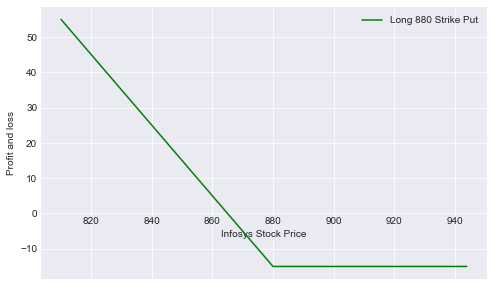

In [ ]:
payoff_long_put = put_payoff(sT, strike_price_long_put, premium_long_put)
# Plot
fig, ax = plt.subplots(figsize=(8,5))
ax.spines['bottom'].set_position('zero')
ax.plot(sT,payoff_long_put,label='Long 880 Strike Put',color='g')
plt.xlabel('Infosys Stock Price')
plt.ylabel('Profit and loss')
plt.legend()
plt.show()

Text(0.5, 0, 'Infosys Stock Price')

Text(0, 0.5, 'Profit and loss')

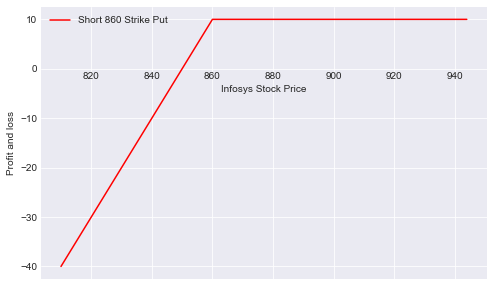

In [ ]:
payoff_short_put = put_payoff(sT, strike_price_short_put, premium_short_put) * -1.0
# Plot
fig, ax = plt.subplots(figsize=(8,5))
ax.spines['bottom'].set_position('zero')
ax.plot(sT,payoff_short_put,label='Short 860 Strike Put',color='r')
plt.xlabel('Infosys Stock Price')
plt.ylabel('Profit and loss')
plt.legend()
plt.show()

Max Profit: 15.0
Max Loss: -5.0


Text(0.5, 0, 'Infosys Stock Price')

Text(0, 0.5, 'Profit and loss')

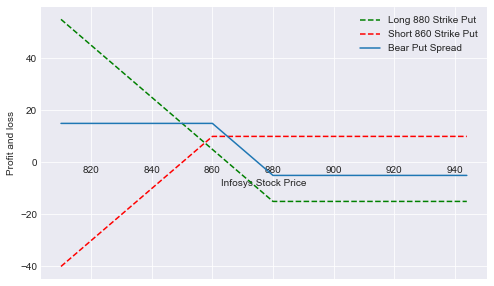

In [ ]:
payoff_bear_put_spread = payoff_long_put + payoff_short_put

print ("Max Profit:", max(payoff_bear_put_spread))
print ("Max Loss:", min(payoff_bear_put_spread))

# Plot
fig, ax = plt.subplots(figsize=(8,5))
ax.spines['bottom'].set_position('zero')
ax.plot(sT,payoff_long_put,'--',label='Long 880 Strike Put',color='g')
ax.plot(sT,payoff_short_put,'--',label='Short 860 Strike Put',color='r')
ax.plot(sT,payoff_bear_put_spread,label='Bear Put Spread')
plt.xlabel('Infosys Stock Price')
plt.ylabel('Profit and loss')
plt.legend()
plt.show()

#### Protective put

In [ ]:
def put_payoff(sT, strike_price, premium):

    return np.where(sT < strike_price, strike_price - sT, 0) - premium

In [ ]:
# Auro Pharma stock price
spot_price = 700

# Auro Pharma stock purchase price
stock_purchase_price = 700

# Long put
strike_price_long_put = 700
premium_long_put = 20

# Stock price range at expiration of the put
sT = np.arange(0.9*spot_price,1.1*spot_price,1)

Text(0.5, 0, 'Auro Pharma Stock Price')

Text(0, 0.5, 'Profit and loss')

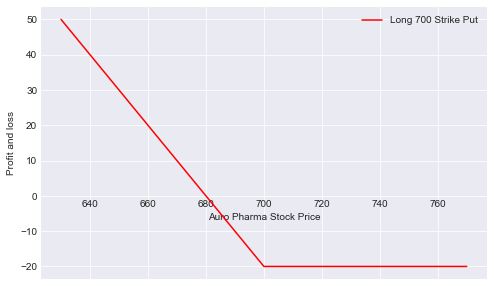

In [ ]:
payoff_long_put = put_payoff(sT, strike_price_long_put, premium_long_put)
# Plot
fig, ax = plt.subplots(figsize=(8,5))
ax.spines['bottom'].set_position('zero')
ax.plot(sT,payoff_long_put,label='Long 700 Strike Put',color='r')
plt.xlabel('Auro Pharma Stock Price')
plt.ylabel('Profit and loss')
plt.legend()
plt.show()

Text(0.5, 0, 'Auro Pharma Stock Price')

Text(0, 0.5, 'Profit and loss')

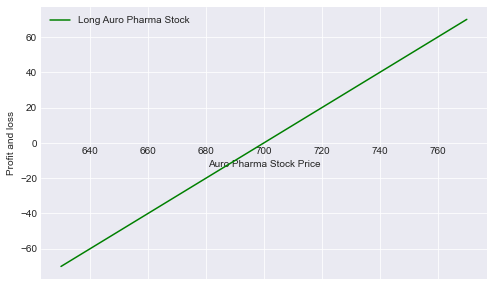

In [ ]:
payoff_auro_pharma_stock = sT - stock_purchase_price
# Plot
fig, ax = plt.subplots(figsize=(8,5))
ax.spines['bottom'].set_position('zero')
ax.plot(sT,payoff_auro_pharma_stock,label='Long Auro Pharma Stock',color='g')
plt.xlabel('Auro Pharma Stock Price')
plt.ylabel('Profit and loss')
plt.legend()
plt.show()

Text(0.5, 0, 'Auro Pharma Stock Price')

Text(0, 0.5, 'Profit and loss')

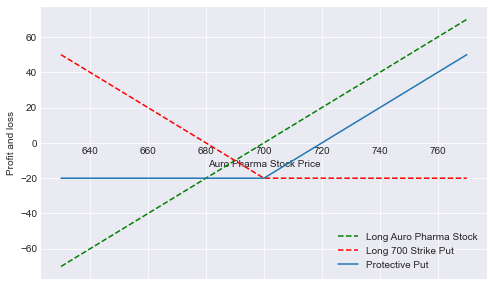

In [ ]:
payoff_protective_put = payoff_auro_pharma_stock + payoff_long_put

# Plot
fig, ax = plt.subplots(figsize=(8,5))
ax.spines['bottom'].set_position('zero')
ax.plot(sT,payoff_auro_pharma_stock,'--',label='Long Auro Pharma Stock',color='g')
ax.plot(sT,payoff_long_put,'--',label='Long 700 Strike Put',color='r')
ax.plot(sT,payoff_protective_put,label='Protective Put')
plt.xlabel('Auro Pharma Stock Price')
plt.ylabel('Profit and loss')
plt.legend()
plt.show()

#### Covered call

In [ ]:
def call_payoff(sT, strike_price, premium):
    return np.where(sT > strike_price, sT - strike_price, 0) - premium

In [ ]:
# Wipro stock price
spot_price = 300

# Short call
strike_price_short_call = 300
premium_short_call = 10

# Stock price range at expiration of the call
sT = np.arange(0.9*spot_price,1.1*spot_price,1)

Text(0.5, 0, 'Wipro Stock Price')

Text(0, 0.5, 'Profit and loss')

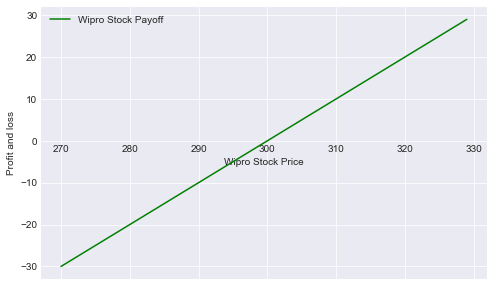

In [ ]:
payoff_wipro_stock = sT-300
fig, ax = plt.subplots(figsize=(8,5))
ax.spines['bottom'].set_position('zero')
ax.plot(sT,payoff_wipro_stock,label='Wipro Stock Payoff',color='g')
plt.xlabel('Wipro Stock Price')
plt.ylabel('Profit and loss')
plt.legend()
plt.show()

Text(0.5, 0, 'Wipro Stock Price')

Text(0, 0.5, 'Profit and loss')

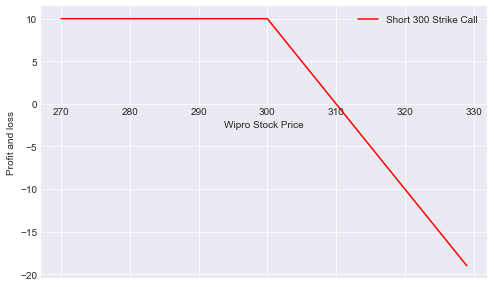

In [ ]:
payoff_short_call = call_payoff(sT, strike_price_short_call, premium_short_call) * -1.0
# Plot
fig, ax = plt.subplots(figsize=(8,5))
ax.spines['bottom'].set_position('zero')
ax.plot(sT,payoff_short_call,label='Short 300 Strike Call',color='r')
plt.xlabel('Wipro Stock Price')
plt.ylabel('Profit and loss')
plt.legend()
plt.show()

Text(0.5, 0, 'Wipro Stock Price')

Text(0, 0.5, 'Profit and loss')

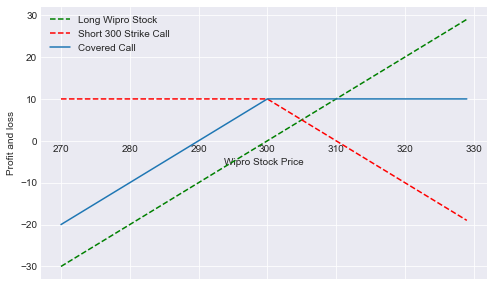

In [ ]:
covered_call_payoff = payoff_wipro_stock + payoff_short_call
# Plot
fig, ax = plt.subplots(figsize=(8,5))
ax.spines['bottom'].set_position('zero')
ax.plot(sT,payoff_wipro_stock,'--',label='Long Wipro Stock',color='g')
ax.plot(sT,payoff_short_call,'--',label='Short 300 Strike Call ',color='r')
ax.plot(sT,covered_call_payoff,label='Covered Call')
plt.xlabel('Wipro Stock Price')
plt.ylabel('Profit and loss')
plt.legend()
plt.show()

Bu web sitesinden kontrol sagla:

https://optioncreator.com/

THYAO ve TKIQB.V: https://optioncreator.com/st0rlgz

THYAO ve TKIQI.V: https://optioncreator.com/stxr3gf
